# Code From QuantumML Work

In [22]:

import importlib
import sympy as sp
import numpy as np
import matplotlib.pyplot as plt
import math
import pandas as pd
from copy import deepcopy
from decimal import Decimal, getcontext, DecimalException
import math
from scipy.optimize import curve_fit
import sympy as sp
from matplotlib.font_manager import FontProperties
import quantum_dl_lib
importlib.reload(quantum_dl_lib)
from quantum_dl_lib import *


In [1]:


# enhanced binary search intersection robust version for large numbers
# default tolerance is 1e-5
def binary_search_intersection(
    func1, func2, low, high, tolerance=1e-9, max_iterations=100000
) -> float:
    """
    Find the intersection of two functions f1(x)=func1(x) and f2(x)=func2(x) (i.e. where f1(x)==f2(x))
    using a robust binary search approach that can handle enormous numbers.

    This version avoids evaluating huge numbers directly by using a "safe" evaluation routine.
    It assumes that on the search interval the functions are positive (so logarithms make sense)
    and that the difference f(x)=func1(x)-func2(x) is monotonic.

    Args:
        func1, func2: The two functions.
        low, high: The endpoints of the search interval.
        tolerance: The acceptable error for f(x) (or its logarithmic version).
        max_iterations: Maximum iterations to try.

    Returns:
        The x-value where the functions intersect, or None if no intersection was found.
    """
    # Use high precision for interval arithmetic.
    getcontext().prec = 100
    low = Decimal(str(low))
    high = Decimal(str(high))
    tol = Decimal(str(tolerance))

    def safe_f(x_dec: Decimal) -> float:
        """
        Evaluate f(x)=func1(x)-func2(x) in a way that avoids overflow.

        If one (or both) function evaluations results in a value that overflows (or is infinite),
        we assign float('inf') to that value. In the case that both are infinite (e.g. for enormous x)
        we instead compare their logarithms.

        Returns:
            A float representing the difference, or the difference of logarithms if needed.
        """
        x = float(x_dec)
        try:
            v1 = func1(x)
        except OverflowError:
            v1 = float("inf")
        try:
            v2 = func2(x)
        except OverflowError:
            v2 = float("inf")

        # If either function evaluates to infinity (or a value that compares as such), we replace it.
        if math.isinf(v1) or math.isinf(v2):
            # If both are infinite and positive, try to compare their logarithms.
            if v1 > 0 and v2 > 0 and math.isinf(v1) and math.isinf(v2):
                try:
                    log_v1 = math.log(func1(x))
                except (OverflowError, ValueError):
                    log_v1 = float("inf")
                try:
                    log_v2 = math.log(func2(x))
                except (OverflowError, ValueError):
                    log_v2 = float("inf")
                return log_v1 - log_v2
            # Otherwise, if only one is infinite, the difference will have the sign of the finite number.
            # (If v1 is infinite and v2 is not, f(x) is positive; if v2 is infinite, f(x) is negative.)
            if math.isinf(v1) and not math.isinf(v2):
                return float("inf")
            if math.isinf(v2) and not math.isinf(v1):
                return -float("inf")
        return v1 - v2

    # Evaluate at the endpoints.
    try:
        f_low = safe_f(low)
        f_high = safe_f(high)
    except (OverflowError, ValueError, DecimalException) as e:
        print("Error evaluating function at endpoints:", e)
        return None

    # Check that f(low) and f(high) bracket a sign change.
    if f_low * f_high > 0:
        # print("No sign change in f(x) over the interval; intersection not guaranteed.")
        return None

    for i in range(max_iterations):
        mid = (low + high) / 2
        f_mid = safe_f(mid)

        # If we are close enough, return.
        if abs(f_mid) < float(tol):
            return float(mid)

        # Decide which side of the interval contains the sign change.
        if f_low * f_mid < 0:
            high = mid
            f_high = f_mid
        else:
            low = mid
            f_low = f_mid

        # If the interval has shrunk sufficiently, exit.
        if abs(high - low) < tol:
            return float(mid)

    # print(f"No intersection found within {max_iterations} iterations")
    return None


# #constants in different format
fidelity_improvement_rate = 0.28
gate_speed_improvement_rate = 0.14
classical_speed_init = 1 / (1.5 * 1e9)  #
superconducting_gate_speed_init = 1e-6  # (1/(1.5*1e9))*(10**3.78) # seconds #overhead taken from quantum economic advantage calculator
initial_error = 10 ** (-2.5)
classical_speed_improvement_rate = 0.3  # moore's law improvement
number_of_processors = 1e8  # processor overehead done from calculations for GPUs
# time_upper_limt = 3.14*1e7 # 1-year of seconds
connectivity_penalty_exponent = 0.0  # connectivity penalty for physical to logical qubit ratio in this range. default no asymptotic connectivity penality
time_upper_limit = 4 * (3.14 * 1e7) / 52  # 1 month computation time
scode_init_speed_overhead = 1e2  # slowdown overhead from Choi, Neil, and Moses
alg_overhead_qubit = 1e1  # algorithm overhead in logical qubits
alg_overhead_qspeed = 1e0  # algorithm speed overhead based on constants this is exclusivly for quantum algorithm
classical_alg_overhead = 1e0
MAX_PROBLEM_SIZE = 1e50
MIN_YEAR = 2025
MAX_YEAR = 2050

# aggressive projection
# constants in different format
# fidelity_improvement_rate = .28
# gate_speed_improvement_rate = .14
# classical_speed_init = 1/(5*1e9) # seconds
# superconducting_gate_speed_init = (1/(5*1e9))*(10**3.78) # seconds #overhead taken from quantum economic advantage calculator
# initial_error = 10**(-2.5)
# classical_speed_improvement_rate = 0.3
# number_of_processors = 1e5
# # time_upper_limt = 3.14*1e7 # 1-year of seconds
# connectivity_penalty_exponent = 0.0 #connectivity penalty for physical to logical qubit ratio in this range.
# time_upper_limit = (3.14*1e7)/12 # 1 week computation time
# surface_code_overhead = 1e2 # number from Choi, Neil, and Moses
# MAX_PROBLEM_SIZE = 1e50
# MIN_YEAR = 2025
# MAX_YEAR = 2050

# default quantum and classical runtime if not specified
classical_runtime = "n**3"
quantum_runtime = "n"

IBM_ROADMAP = {
    2020: 27,
    2022: 127,
    2024: 133,
}
GOOGLE_ROADMAP = {
    2019: 53,
    2024: 105,
}
PERCENTILE_95_ROADMAP = {
    2025: 1662,
    2030: 15660,
}
SOTA_ROADMAP = {
    2025: 1959,
    2030: 24352,
}
percentile_90_roadmap = {
   2025:305.13,
   2030:1315
}

default_roadmap = percentile_90_roadmap


# gives the physical to logical overhead based on the surface code formula
def surface_code_formula(pP: float) -> float:
    pL = 1e-18
    pth = 1e-2
    numerator = 4 * math.log(math.sqrt(10 * pP / pL))
    denominator = math.log(pth / pP)
    fraction = numerator / denominator
    f_QEC = (fraction + 1) ** -2
    return f_QEC**-1


def problem_size_qubit_feasible(
    year: int, roadmap: dict = default_roadmap,  alg_overhead: float = 1, q_prob_size="log"
) -> float:

    # fit exponential to roadmap
    years = np.array(list(roadmap.keys()))
    qubits = np.array(list(roadmap.values()))
    min_year = min(years)
    # initial gues
    p0 = [min(qubits), 0.5, 0]

    # fit an exponential curve to the data
    def exp_func(x, a, b, c):
        return a * np.exp(b * (x - min_year)) + c

    try:
        popt, _ = curve_fit(
            exp_func, years, qubits, p0=p0, bounds=([0, -2, -1000], [10000, 2, 1000])
        )
    except RuntimeError:
        # print(f"Fitting failed for {label}")
        return None
    surf_overhead = surface_code_formula(
        initial_error * (1-fidelity_improvement_rate) ** (year - 2025)
    )
    if q_prob_size == "log":
        qubit_number = min(
            exp_func(year, *popt) / (surf_overhead * alg_overhead_qubit),
            np.log2(MAX_PROBLEM_SIZE),
        )
        return 2 ** (qubit_number)
    else:
        return min(
            exp_func(year, *popt) / (surf_overhead * alg_overhead_qubit),
            MAX_PROBLEM_SIZE,
        )


# quantum speed per operation function
def quantum_seconds_per_operation(year):
    gate_speed = superconducting_gate_speed_init * (
        1 - gate_speed_improvement_rate
    ) ** (year - 2025)
    # with error correction
    fidelity_year = initial_error * (1-fidelity_improvement_rate) ** (year - 2025)
    proportional_change = (surface_code_formula(fidelity_year)) / surface_code_formula(
        initial_error
    )
    return gate_speed * scode_init_speed_overhead * proportional_change ** (1.5)


# seconds per effective operation ie here we factor in parallelism
def classical_seconds_per_operation(year):
    # just dividing by number of processors here for now to simplify things
    return (
        1e-9
        * (1 - classical_speed_improvement_rate) ** (year - 2025)
        / number_of_processors
    )


# maximum problem size that can be solved on a quantum computer in a given amount of time at a given year
def find_largest_problem_size(
    runtime_string,
    year: int,
    quantum=True,
    qadv_only=False,
    roadmap: dict = default_roadmap,
    stagnation_year=2200,
    time_upper_limit=time_upper_limit,
    q_prob_size="log",
) -> float:
    # Constants
    try:
        # Convert string expression to lambda function
        n = sp.Symbol("n")
        expr = sp.sympify(runtime_string)
        expr = expr * n**connectivity_penalty_exponent * alg_overhead_qspeed
        # Apply connectivity penalty to the runtime
        runtime_func = sp.lambdify(n, expr)

        if quantum:
            quantum_total = lambda size: quantum_seconds_per_operation(
                year
            ) * runtime_func(size)

            def quantum_limit(x):
                return time_upper_limit  # number of seconds in a year
                # return q_ops_second_dollar

            qadv = binary_search_intersection(
                quantum_total, quantum_limit, low=2.5, high=1e50
            )
            if qadv is None:
                # print(f"No intersection found between quantum total and limit for year {year}")
                qadv = float("inf")
            # except Exception as e:
            #     print(f"Error finding intersection for year {year}: {e}")
            #     return float("inf")

            size_feasible = problem_size_qubit_feasible(
                roadmap=roadmap, year=year, q_prob_size=q_prob_size
            )
            # Handle the case where size_feasible is None
            if size_feasible is None:
                print(f"No feasible size found for year {year}. Returning infinity.")
                return float("inf")  # Return infinity if no feasible size is found
            if not qadv_only:
                return min(qadv, size_feasible)
            else:
                return qadv

        else:

            def classical_cost(x):
                if year < stagnation_year:
                    return classical_seconds_per_operation(year) * runtime_func(x)
                else:
                    return classical_seconds_per_operation(
                        stagnation_year
                    ) * runtime_func(x)

            def classical_limit(x):
                return time_upper_limit
                # return ops_second_dollar

            return binary_search_intersection(
                classical_cost, classical_limit, low=2.5, high=1e50
            )

    except Exception as e:
        print(f"Error in function evaluation: {e}")
        return None


def quantum_advantage_size_by_year(
    year, classical_runtime_string: str, quantum_runtime_string: str
) -> float:
    n = sp.symbols("n")
    class_expr = sp.sympify(classical_runtime_string)
    class_expr = (
        class_expr * classical_seconds_per_operation(year) * classical_alg_overhead
    )
    classical_runtime_func = sp.lambdify(n, class_expr)

    quant_expr = sp.sympify(quantum_runtime_string)
    quant_expr = quant_expr * n**connectivity_penalty_exponent * alg_overhead_qspeed
    quant_expr = quant_expr * quantum_seconds_per_operation(year)
    quantum_runtime_func = sp.lambdify(n, quant_expr)

    # Find intersection using the original string expressions
    return binary_search_intersection(
        classical_runtime_func, quantum_runtime_func, 2.5, 1e50
    )


# this is the intersection of quantum advantage size by year and quantum problem size qubit feasible by year
def generalized_qea(
    classical_runtime_string: str, quantum_runtime_string: str
) -> float:
    return binary_search_intersection(
        lambda x: quantum_advantage_size_by_year(
            x, classical_runtime_string, quantum_runtime_string
        ),
        lambda x: find_largest_problem_size(quantum_runtime_string, x, quantum=True),
        MIN_YEAR,
        MAX_YEAR,
    )


In [24]:
surface_code_formula(10**-2.5)
classical_runtime = "n"
quantum_runtime = "log(n,2)"
# Calculate the quantum advantage size for each year
classical_alg_overhead = 1e4

print(quantum_advantage_size_by_year(2027, classical_runtime, quantum_runtime))
print("largest problem size", find_largest_problem_size(quantum_runtime, 2027, quantum=True))

12745089795.227076
largest problem size 1.0139228740781636


/Users/hansgundlach/Documents/AllOtherResearch/NeelMaterial/othello/lib/python3.9/site-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


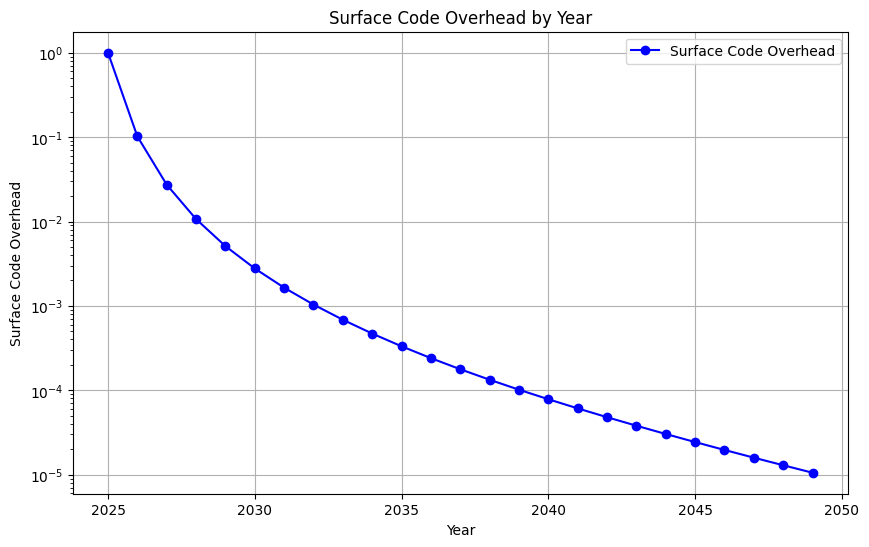

1.0
1.0


In [25]:
# graph suface code overhead over time
years = np.arange(2025, 2050)
surface_code_overhead_init = surface_code_formula(initial_error*fidelity_improvement_rate**(2025-2025))
surface_code_overhead_list = [(surface_code_formula(initial_error*fidelity_improvement_rate**(year-2025))/surface_code_formula(initial_error))**1.5 for year in years]
plt.figure(figsize=(10, 6))
plt.plot(years, surface_code_overhead_list, marker='o', linestyle='-', color='b', label='Surface Code Overhead')
plt.xlabel('Year')
plt.yscale('log')
plt.ylabel('Surface Code Overhead')
plt.title('Surface Code Overhead by Year')
plt.grid(True)
plt.legend()
plt.show()
print(surface_code_overhead_list[0])
print(surface_code_formula(initial_error*(fidelity_improvement_rate**(2025-2025)))/surface_code_formula(initial_error))



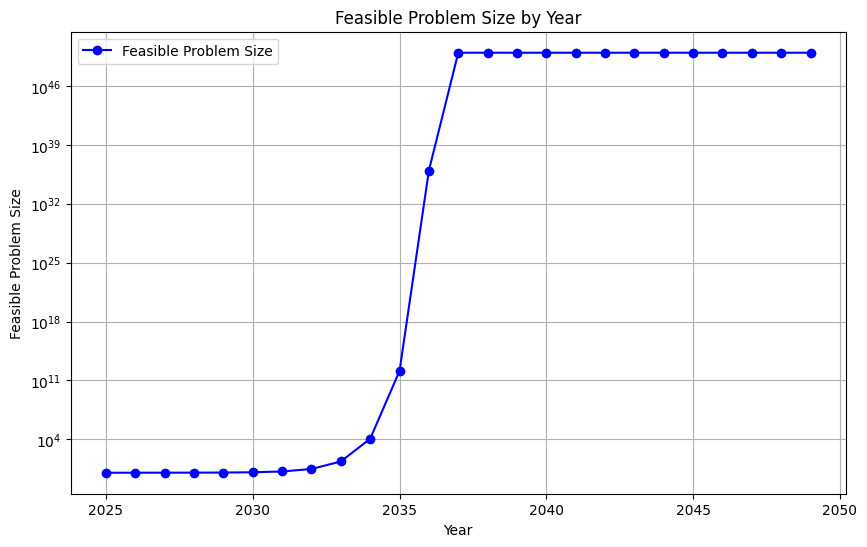

In [26]:
#graph problem_size_qubit_feasible
years = np.arange(2025, 2050)
feasible_sizes = [problem_size_qubit_feasible(roadmap=percentile_90_roadmap, year=year) for year in years]
plt.figure(figsize=(10, 6))
plt.plot(years, feasible_sizes, marker='o', linestyle='-', color='b', label='Feasible Problem Size')
plt.xlabel('Year')
plt.ylabel('Feasible Problem Size')

plt.title('Feasible Problem Size by Year')
plt.grid(True)
plt.legend()
plt.yscale('log')

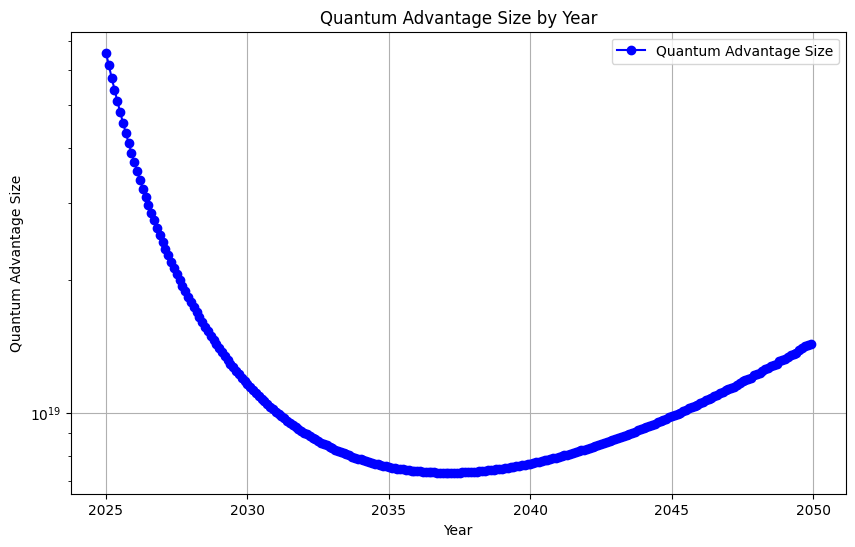

In [31]:

# Define the range of years
# years = range(2025, 2050)
years = np.arange(2025, 2050, 0.1)
classical_alg_overhead = 1e-5
classical_runtime = "n"
quantum_runtime = "log(n,2)"
# Calculate the quantum advantage size for each year
quantum_advantage_sizes = [quantum_advantage_size_by_year(year, classical_runtime, quantum_runtime) for year in years]

# Filter out None values for plotting
filtered_years = [year for year, size in zip(years, quantum_advantage_sizes) if size is not None]
filtered_sizes = [size for size in quantum_advantage_sizes if size is not None]

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(filtered_years, filtered_sizes, marker='o', linestyle='-', color='b', label='Quantum Advantage Size')
plt.xlabel('Year')
plt.ylabel('Quantum Advantage Size')
plt.title('Quantum Advantage Size by Year')
plt.grid(True)
plt.legend()
plt.yscale('log')
plt.show()

# Google_roadmap = {
#     2019: 54,
#     2023: 100,
#     2025: 1000,
# }

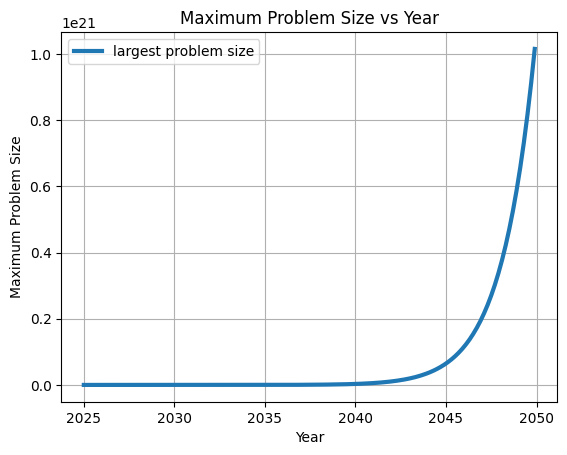

In [32]:

years = np.arange(2025, 2050, 0.1)
quantum_runtime = "n**0.5"
largest_problem_size = [find_largest_problem_size(quantum_runtime, year, roadmap=percentile_90_roadmap, quantum=True, q_prob_size="log", time_upper_limit=1e2) for year in years]
plt.plot(years, largest_problem_size, label="largest problem size", linewidth=3)
plt.xlabel("Year")
plt.ylabel("Maximum Problem Size")
plt.title("Maximum Problem Size vs Year")
plt.legend()
plt.grid(True)


In [9]:
# # Create a figure with three subplots side by side
# fig, axes = plt.subplots(1, 3, figsize=(24, 7), sharey=True)
# plt.ylim(top=1e25)

# #constant adjustment 
# alg_overhead_qspeed = 1e0
# alg_overhead_qubit = 1e0
# classical_alg_overhead = 1e0

# # Second subplot - n^2 QPE
# classical_runtime_linear = "n"
# quantum_runtime_log = "log(n,2)"



# annotation_size = 20

# quantum_problem_sizes_n2 = [
#     find_largest_problem_size(quantum_runtime_log, year, quantum=True) for year in years
# ]
# # quantum_economic_advantages_fci_n2 = [
# #     quantum_advantage_size_by_year(year, classical_runtime_string=classical_runtime_linear, quantum_runtime_string=quantum_runtime_log) for year in years
# # ]
# # def find_largest_problem_size_func_n2(year):
# #     return find_largest_problem_size(quantum_runtime_log, year, quantum=True)

# Graph of Chemistry 

In [10]:
surface_code_formula(1e-4)

255.99999999999994

In [11]:
# test find largest problem size
runtime_string = "n**8"
year = 2030
# find_largest_problem_size(runtime_expr, year, quantum=True, qadv_only=False, stagnation_year=2200, time_upper_limit=6*1e5)
# binary_search_intersection(lambda x: x**8, lambda x: 6*1e5, 1.0, 1e50)

binary_search_intersection(lambda x: x**8, lambda x: 6*1e5, 1.0, 1e50)


5.275564125789451

# Descriptive Version for Paper 

[9.999999999999999e+25, 7.743274810422674e+25, 6.101731118255945e+25, 4.884554937760474e+25, 3.966330092391398e+25, 3.262735341819994e+25, 2.7159049692548606e+25, 2.285381831401916e+25, 1.9423950772591525e+25, 1.6661632592890964e+25, 1.4414591700306661e+25, 1.2569769296972219e+25, 1.1042188744945053e+25, 9.767251479442407e+24, 8.695329050001219e+24, 7.787916775372776e+24, 7.014864369561005e+24, 6.352359031279802e+24, 5.781440708164653e+24, 5.286898059540658e+24, 4.856439694069298e+24, 4.4800664725843796e+24, 4.1495920770730886e+24, 3.8582738992023797e+24, 3.6005267149217556e+24, 3.3716989861331604e+24, 3.167896902887493e+24, 2.98584508338761e+24, 2.822775616989148e+24, 2.676339166004046e+24, 2.5445333434464243e+24, 2.425644702121565e+24, 2.3182015093015135e+24, 2.2209351147359222e+24, 2.132748201277478e+24, 2.0526885756884185e+24, 1.979927440539753e+24, 1.9137413073546393e+24, 1.8534968817106714e+24, 1.7986383844074284e+24, 1.7486768776541542e+24, 1.703181248043224e+24, 1.6617705637891

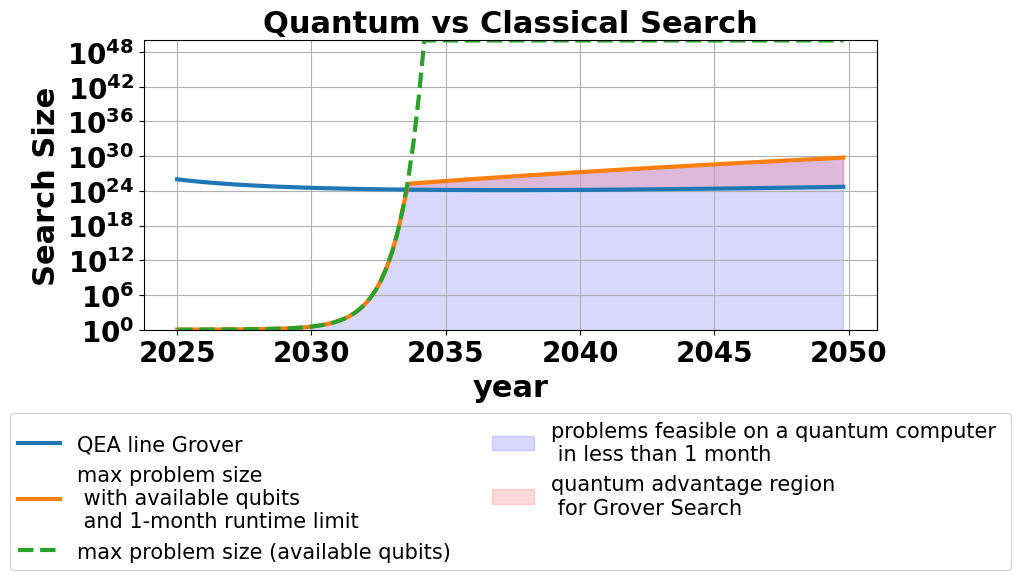

In [33]:
#bolder version for poster 

classical_runtime_search = "n"
quantum_runtime = "n**0.5"


alg_overhead_qspeed = 1e0
alg_overhead_qubit = 1e0
classical_alg_overhead = 1e0
# graph largeset problem size vs year for grovers algorithms
years = np.arange(MIN_YEAR, MAX_YEAR, .2)



#set figsize
plt.figure(figsize=(10, 7))
roadmap = default_roadmap


qubit_feasible_line= [problem_size_qubit_feasible(roadmap=roadmap, year=year, q_prob_size="log") for year in years]

# plt.plot(years, qubit_feasible_line, label="max problem size (available qubits)", linewidth=3, linestyle='--')

quantum_problem_sizes = [
    find_largest_problem_size(quantum_runtime, year, quantum=True, q_prob_size="log") for year in years
]


quantum_economic_advantages_grover = [
    quantum_advantage_size_by_year(year, classical_runtime_string=classical_runtime_search, quantum_runtime_string=quantum_runtime) for year in years
]
print(quantum_economic_advantages_grover)
plt.plot(years, quantum_economic_advantages_grover, label="QEA line Grover", linewidth=3)

def find_largest_problem_size_func(year):
    return find_largest_problem_size(quantum_runtime, year, quantum=True, q_prob_size="log")

def quantum_advantage_size_by_year_func(year):
    return quantum_advantage_size_by_year(year, classical_runtime_string=classical_runtime, quantum_runtime_string=quantum_runtime)
# Find the intersection year using binary search
intersection_year = binary_search_intersection(find_largest_problem_size_func, quantum_advantage_size_by_year_func, MIN_YEAR, MAX_YEAR)


# Find the intersection value
intersection_value = find_largest_problem_size(quantum_runtime, intersection_year, quantum=True, q_prob_size="log")
print("the intersection value is", intersection_value)
#====================================================================================================


plt.plot(years, quantum_problem_sizes, label="max problem size \n with available qubits \n and 1-month runtime limit", linewidth=3)
# plt.plot(years, quantum_economic_advantages_ccsd, label="quantum economic advantage ccsd", linewidth=3)
# plt.plot(years, quantum_economic_advantages_ccsdpt, label="quantum economic advantage ccsdpt", linewidth=3)
# plt.plot(years, quantum_economic_advantages_grover, label="QEA line Grover", linewidth=3)
# plt.plot(years, quantum_economic_advantages_mp2, label="quantum economic advantage mp2", linewidth=3)
plt.plot(years, qubit_feasible_line, label="max problem size (available qubits)", linewidth=3, linestyle='--')


# plt.plot(years, classical_problem_sizes_ccsdpt, label="ccsdpt max computable problem size (1-week)", linewidth=3)
plt.ylabel("Search Size", fontsize=22, fontweight='bold')
plt.xlabel("year", fontsize=22, fontweight='bold')
tick_positions = np.logspace(0, 50, num=10, base=10)
plt.xticks(fontsize=20, fontweight='bold')
plt.yticks(fontsize=20, fontweight='bold')
plt.yscale("log")
plt.title("Quantum vs Classical Search", fontsize=22, fontweight='bold')
plt.grid() 
#move the legend to the upper right


plt.ylim(1e0, 1e50)
plt.fill_between(years, 0, quantum_problem_sizes,
                    color='blue', alpha=0.15, label='problems feasible on a quantum computer \n in less than 1 month')
plt.fill_between(years, quantum_economic_advantages_grover, quantum_problem_sizes,
                 color='red', alpha=0.15, label='quantum advantage region \n for Grover Search',
                 where=(np.array(quantum_problem_sizes) >= np.array(quantum_economic_advantages_grover)))

plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.25), ncol=2, fontsize=15)
# Adjust layout to prevent text cutoff

#====================================================================
# Find intersection between quantum max computable problem size and quantum economic advantage fci
intersection_year_grover = binary_search_intersection(
    find_largest_problem_size_func,
    lambda year: quantum_advantage_size_by_year(year, classical_runtime_string=classical_runtime_search, quantum_runtime_string=quantum_runtime),
    2025, 2050
)
print("the intersection year of fci and quantum max computable problem size is ", intersection_year_grover)
intersection_value_grover = find_largest_problem_size(quantum_runtime, intersection_year_grover, quantum=True)

# Plot the intersection point
# plt.plot(intersection_year_grover, intersection_value_grover, 'ro', color="black")
# plt.annotate(f'{round(intersection_year_grover)}',
#             xy=(intersection_year_grover, intersection_value_grover),
#             xytext=(10, 10), textcoords='offset points', fontsize=15, fontweight='bold')




plt.tight_layout(rect=[0, 0, 1, 0.95], pad=1.5)  # Add padding and adjust height
plt.savefig("Figures/generalized_qea_model.png", bbox_inches='tight', dpi=300)  # Use bbox_inches to


# N^2 QPE Quantum Advantage Lines

In [13]:
# #bolder version for poster 
# classical_runtime = "n**6"
# quantum_runtime = "1e3*n**2"
# classical_runtime_ccsdpt = "n**8"
# classical_runtime_search = "2**n"
# classical_runtime_mp2 = "n**5"

# # graph largeset problem size vs year for grovers algorithms
# years = np.arange(2025, 2050, .2)
# quantum_problem_sizes = [
#     find_largest_problem_size(quantum_runtime, year, quantum=True) for year in years
# ]
# print(classical_problem_sizes_ccsdpt)

# quantum_economic_advantages_ccsd = [
#     quantum_advantage_size_by_year(year, classical_runtime_string=classical_runtime, quantum_runtime_string=quantum_runtime) for year in years
# ]
# quantum_economic_advantages_ccsdpt = [
#     quantum_advantage_size_by_year(year, classical_runtime_string=classical_runtime_ccsdpt, quantum_runtime_string=quantum_runtime) for year in years
# ]
# quantum_economic_advantages_grover = [
#     quantum_advantage_size_by_year(year, classical_runtime_string=classical_runtime_search, quantum_runtime_string=quantum_runtime) for year in years
# ]
# quantum_economic_advantages_mp2 = [
#     quantum_advantage_size_by_year(year, classical_runtime_string=classical_runtime_mp2, quantum_runtime_string=quantum_runtime) for year in years
# ]
# quantum_advantage_size_by_year_list= [
# quantum_advantage_size_by_year(year, classical_runtime_string=classical_runtime, quantum_runtime_string=quantum_runtime) for year in years
# ]

# def find_largest_problem_size_func(year):
#     return find_largest_problem_size(quantum_runtime, year, quantum=True)

# def quantum_advantage_size_by_year_func(year):
#     return quantum_advantage_size_by_year(year, classical_runtime_string=classical_runtime, quantum_runtime_string=quantum_runtime)
# # Find the intersection year using binary search
# intersection_year = binary_search_intersection(find_largest_problem_size_func, quantum_advantage_size_by_year_func, 2025, 2050)

# # Find the intersection value
# intersection_value = find_largest_problem_size(quantum_runtime, intersection_year, quantum=True)
# #====================================================================================================

# #plotting code 
# plt.figure(figsize=(10, 6))
# #plotting code 
# plt.plot(years, quantum_problem_sizes, label="quantum max computable problem size (1-week)", linewidth=3)
# plt.plot(years, quantum_economic_advantages_ccsd, label="quantum economic advantage ccsd", linewidth=3)
# plt.plot(years, quantum_economic_advantages_ccsdpt, label="quantum economic advantage ccsdpt", linewidth=3)
# plt.plot(years, quantum_economic_advantages_grover, label="quantum economic advantage fci", linewidth=3)
# plt.plot(years, quantum_economic_advantages_mp2, label="quantum economic advantage mp2", linewidth=3)
# # plt.plot(years, classical_problem_sizes_ccsd, label="ccsd max computable problem size (1-week)", linewidth=3)
# # plt.plot(years, classical_problem_sizes_stagnation, label="classical stagnation")
# # plt.plot(years, quantum_advantage_size_by_year_list, label="quantum economic advantage", linewidth=3)

# # plt.plot(years, classical_problem_sizes_ccsdpt, label="ccsdpt max computable problem size (1-week)", linewidth=3)
# plt.ylabel("problem size", fontsize=22, fontweight='bold')
# plt.xlabel("year", fontsize=22, fontweight='bold')
# tick_positions = np.logspace(0, 50, num=10, base=10)
# plt.xticks(fontsize=20, fontweight='bold')
# plt.yticks(fontsize=20, fontweight='bold')
# plt.yscale("log")
# plt.title("Quantum vs Classical Chemistry Methods (n^2 QPE)", fontsize=22, fontweight='bold')
# plt.grid() 
# #move the legend to the upper right
# plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.25), ncol=2, fontsize=15)

# plt.ylim(1e0)
# # Find intersection between quantum problem sizes and quantum advantage size
# # intersection_year, intersection_value = find_intersection_year(
# #     years, 
# #     quantum_problem_sizes,
# #     quantum_advantage_size_by_year_list
# # )

# # plt.plot(intersection_year, intersection_value, 'ro', label='Intersection', color="black")
# # intersection_year = int(round(intersection_year))
# # plt.annotate(f'{intersection_year}',
# #             xy=(intersection_year, intersection_value),
# #             xytext=(10, 10), textcoords='offset points', fontsize=12)

# # plt.fill_between(years, quantum_advantage_size_by_year_list, quantum_problem_sizes,
# #                     where=(np.array(quantum_problem_sizes) >= np.array(quantum_advantage_size_by_year_list)),
# #                     color='blue', alpha=0.15, label='Problems Feasible and Advantageous')
# plt.fill_between(years, 0, quantum_problem_sizes,
#                     color='blue', alpha=0.15, label='Problems with Quantum Economic Advantage')
# # Adjust layout to prevent text cutoff
# plt.tight_layout(rect=[0, 0, 1, 0.95], pad=1.5)  # Add padding and adjust height
# plt.savefig("Figures/qea_chemistry_graph.png", bbox_inches='tight', dpi=300)  # Use bbox_inches to prevent cutoff

# # plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))


# # plt.legend(loc='upper center', bbox_to_anchor=(0.5, -.22), ncol=2)

# # plt.plot(intersection_year, intersection_value, 'ro', label='Intersection', color="black")
# # intersection_year = int(round(intersection_year))
# # plt.annotate(f'{intersection_year}',
# #             xy=(intersection_year, intersection_value),
# #             xytext=(10, 10), textcoords='offset points', fontsize=20, fontweight='bold')



# N^5 Analysis and Older Asymptotic Times

In [14]:
# #bolder version for poster 
# classical_runtime = "n**6"
# quantum_runtime = "1e3*n**5"
# classical_runtime_ccsdpt = "n**8"
# classical_runtime_search = "2**n"
# # graph largeset problem size vs year for grovers algorithms
# years = np.arange(2025, 2050, .2)
# quantum_problem_sizes = [
#     find_largest_problem_size(quantum_runtime, year, quantum=True) for year in years
# ]
# print(classical_problem_sizes_ccsdpt)

# quantum_economic_advantages_ccsd = [
#     quantum_advantage_size_by_year(year, classical_runtime_string=classical_runtime, quantum_runtime_string=quantum_runtime) for year in years
# ]
# quantum_economic_advantages_ccsdpt = [
#     quantum_advantage_size_by_year(year, classical_runtime_string=classical_runtime_ccsdpt, quantum_runtime_string=quantum_runtime) for year in years
# ]
# quantum_economic_advantages_grover = [
#     quantum_advantage_size_by_year(year, classical_runtime_string=classical_runtime_search, quantum_runtime_string=quantum_runtime) for year in years
# ]
# quantum_advantage_size_by_year_list= [
# quantum_advantage_size_by_year(year, classical_runtime_string=classical_runtime, quantum_runtime_string=quantum_runtime) for year in years
# ]

# def find_largest_problem_size_func(year):
#     return find_largest_problem_size(quantum_runtime, year, quantum=True)

# def quantum_advantage_size_by_year_func(year):
#     return quantum_advantage_size_by_year(year, classical_runtime_string=classical_runtime, quantum_runtime_string=quantum_runtime)
# # Find the intersection year using binary search
# intersection_year = binary_search_intersection(find_largest_problem_size_func, quantum_advantage_size_by_year_func, 2025, 2050)

# # Find the intersection value
# intersection_value = find_largest_problem_size(quantum_runtime, intersection_year, quantum=True)
# #====================================================================================================

# #plotting code 
# plt.figure(figsize=(10, 6))
# #plotting code 
# plt.plot(years, quantum_problem_sizes, label="quantum max computable problem size (1-week)", linewidth=3)
# # plt.plot(years, quantum_economic_advantages_ccsd, label="quantum economic advantage ccsd", linewidth=3)
# plt.plot(years, quantum_economic_advantages_ccsdpt, label="quantum economic advantage ccsdpt", linewidth=3)
# plt.plot(years, quantum_economic_advantages_grover, label="quantum economic advantage fci", linewidth=3)
# # plt.plot(years, classical_problem_sizes_ccsd, label="ccsd max computable problem size (1-week)", linewidth=3)
# # plt.plot(years, classical_problem_sizes_stagnation, label="classical stagnation")
# # plt.plot(years, quantum_advantage_size_by_year_list, label="quantum economic advantage", linewidth=3)

# # plt.plot(years, classical_problem_sizes_ccsdpt, label="ccsdpt max computable problem size (1-week)", linewidth=3)
# plt.ylabel("problem size", fontsize=22, fontweight='bold')
# plt.xlabel("year", fontsize=22, fontweight='bold')
# tick_positions = np.logspace(0, 50, num=10, base=10)
# plt.xticks(fontsize=20, fontweight='bold')
# plt.yticks(fontsize=20, fontweight='bold')
# plt.yscale("log")
# plt.title("Quantum vs Classical Chemistry Methods (n^5 QPE)", fontsize=22, fontweight='bold')
# plt.grid() 
# #move the legend to the upper right
# plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.25), ncol=2, fontsize=15)

# plt.ylim(1e0)
# plt.fill_between(years, 0, quantum_problem_sizes,
#                     color='blue', alpha=0.15, label='Problems with Quantum Economic Advantage')
# # Adjust layout to prevent text cutoff
# plt.tight_layout(rect=[0, 0, 1, 0.95], pad=1.5)  # Add padding and adjust height


# # Find intersection point for FCI with n^3 QPE
# def quantum_advantage_size_by_year_func_fci_n3(year):
#     return quantum_advantage_size_by_year(year, classical_runtime_string=classical_runtime_search, quantum_runtime_string=quantum_runtime)

# # Find the intersection year using binary search for FCI
# intersection_year_fci_n3 = binary_search_intersection(find_largest_problem_size_func_n3, quantum_advantage_size_by_year_func_fci_n3, 2025, 2050)

# # Find the intersection value for FCI
# intersection_value_fci_n3 = find_largest_problem_size(quantum_runtime, intersection_year_fci_n3, quantum=True)

# # Plot the intersection point for FCI
# plt.plot(intersection_year_fci_n3, intersection_value_fci_n3, 'ro', color="black")
# plt.annotate(f'{int(round(intersection_year_fci_n3))}',
#             xy=(intersection_year_fci_n3, intersection_value_fci_n3),
#             xytext=(10, 10), textcoords='offset points', fontsize=15, fontweight='bold')

# plt.savefig("Figures/qea_chemistry_graph.png", bbox_inches='tight', dpi=300)  # 

# Plausible Single Form Graph 

In [15]:
# alg_overhead_qubit = 1e1
# alg_overhead_qspeed = 1e0
# classical_alg_overhead_speed = 1e0

# # bolder version for poster 
# classical_runtime = "n**6"
# quantum_runtime = "1e3*n**3"
# classical_runtime_ccsdpt = "n**8"
# classical_runtime_search = "2**n"
# # graph largeset problem size vs year for grovers algorithms
# years = np.arange(2025, 2050, .2)
# quantum_problem_sizes = [
#     find_largest_problem_size(quantum_runtime, year, quantum=True) for year in years
# ]
# # print(classical_problem_sizes_ccsdpt)

# quantum_economic_advantages_ccsd = [
#     quantum_advantage_size_by_year(year, classical_runtime_string=classical_runtime, quantum_runtime_string=quantum_runtime) for year in years
# ]
# quantum_economic_advantages_ccsdpt = [
#     quantum_advantage_size_by_year(year, classical_runtime_string=classical_runtime_ccsdpt, quantum_runtime_string=quantum_runtime) for year in years
# ]

# quantum_economic_advantages_grover = [
#     quantum_advantage_size_by_year(year, classical_runtime_string=classical_runtime_search, quantum_runtime_string=quantum_runtime) for year in years
# ]
# quantum_advantage_size_by_year_list= [
# quantum_advantage_size_by_year(year, classical_runtime_string=classical_runtime, quantum_runtime_string=quantum_runtime) for year in years
# ]

# def find_largest_problem_size_func(year):
#     return find_largest_problem_size(quantum_runtime, year, quantum=True)

# def quantum_advantage_size_by_year_func(year):
#     return quantum_advantage_size_by_year(year, classical_runtime_string=classical_runtime, quantum_runtime_string=quantum_runtime)
# # Find the intersection year using binary search
# intersection_year = binary_search_intersection(find_largest_problem_size_func, quantum_advantage_size_by_year_func, 2025, 2050)

# # Find the intersection value
# intersection_value = find_largest_problem_size(quantum_runtime, intersection_year, quantum=True)
# #====================================================================================================

# #plotting code 
# plt.figure(figsize=(10, 6))
# #plotting code 
# plt.plot(years, quantum_problem_sizes, label="quantum max computable problem size (1-week)", linewidth=3)
# plt.plot(years, quantum_economic_advantages_grover, label="quantum economic advantage FCI", linewidth=3)
# plt.plot(years, quantum_economic_advantages_ccsd, label="quantum economic advantage CCSD", linewidth=3)
# plt.plot(years, quantum_economic_advantages_ccsdpt, label="quantum economic advantage CCSD(T)", linewidth=3)
# # plt.plot(years, classical_problem_sizes_ccsd, label="ccsd max computable problem size (1-week)", linewidth=3)
# # plt.plot(years, classical_problem_sizes_stagnation, label="classical stagnation")
# # plt.plot(years, quantum_advantage_size_by_year_list, label="quantum economic advantage", linewidth=3)

# # plt.plot(years, classical_problem_sizes_ccsdpt, label="ccsdpt max computable problem size (1-week)", linewidth=3)
# plt.ylabel("problem size", fontsize=22, fontweight='bold')
# plt.xlabel("year", fontsize=22, fontweight='bold')
# tick_positions = np.logspace(0, 50, num=10, base=10)
# plt.xticks(fontsize=20, fontweight='bold')
# plt.yticks(fontsize=20, fontweight='bold')
# plt.yscale("log")
# plt.title("Quantum Economic Advantage ($\mathbf{N^3}$ QPE)", fontsize=22, fontweight='bold')
# plt.grid()
# #move the legend to the upper right


# plt.ylim(1e0)
# plt.fill_between(years, 0, quantum_problem_sizes,
#                     color='blue', alpha=0.15, label='problems feasible on a quantum computer')
# # Adjust layout to prevent text cutoff
# plt.tight_layout(rect=[0, 0, 1, 0.95], pad=1.5)  # Add padding and adjust height


# prop = {'size': 16, 'weight': 'bold'}
# plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.25), ncol=2, prop=prop)






# # Find intersection point for FCI with n^3 QPE
# def quantum_advantage_size_by_year_func_fci_n3(year):
#     return quantum_advantage_size_by_year(year, classical_runtime_string=classical_runtime_search, quantum_runtime_string=quantum_runtime)

# # Find the intersection year using binary search for FCI
# intersection_year_fci_n3 = binary_search_intersection(find_largest_problem_size_func_n3, quantum_advantage_size_by_year_func_fci_n3, 2025, 2050)

# # Find the intersection value for FCI
# intersection_value_fci_n3 = find_largest_problem_size(quantum_runtime, intersection_year_fci_n3, quantum=True)

# # Plot the intersection point for FCI
# plt.plot(intersection_year_fci_n3, intersection_value_fci_n3, 'ro', color="black")
# plt.annotate(f'{int(round(intersection_year_fci_n3))}',
#             xy=(intersection_year_fci_n3, intersection_value_fci_n3),
#             xytext=(10, 10), textcoords='offset points', fontsize=20, fontweight='bold')


# def quantum_economic_advantage_ccsdpt_n3(year):
#     return quantum_advantage_size_by_year(year, classical_runtime_string=classical_runtime_ccsdpt, quantum_runtime_string=quantum_runtime)

# #plot intersection point for ccsdpt
# intersection_year_ccsdpt_n3 = binary_search_intersection(find_largest_problem_size_func, quantum_economic_advantage_ccsdpt_n3, 2025, 2050)
# intersection_value_ccsdpt_n3 = find_largest_problem_size(quantum_runtime, intersection_year_ccsdpt_n3, quantum=True)
# plt.plot(intersection_year_ccsdpt_n3, intersection_value_ccsdpt_n3, 'ro', color="black")
# plt.annotate(f'{int(round(intersection_year_ccsdpt_n3))}',
#             xy=(intersection_year_ccsdpt_n3, intersection_value_ccsdpt_n3),
#             xytext=(10, 10), textcoords='offset points', fontsize=20, fontweight='bold')

# plt.savefig("Figures/n3_chemistry_graph.png", bbox_inches='tight', dpi=300)  # 

# All Plots as Subplots: ie the Triptic

/var/folders/lp/hk0h_6g94b59251kmlwhp32h0000gn/T/ipykernel_79008/1537652102.py:50: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "ro" (-> color='r'). The keyword argument will take precedence.
  axes[0].plot(intersection_year_fci_n2, intersection_value_fci_n2, 'ro', color="black")
/var/folders/lp/hk0h_6g94b59251kmlwhp32h0000gn/T/ipykernel_79008/1537652102.py:101: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "ro" (-> color='r'). The keyword argument will take precedence.
  axes[1].plot(intersection_year_fci_n3, intersection_value_fci_n3, 'ro', color="black")


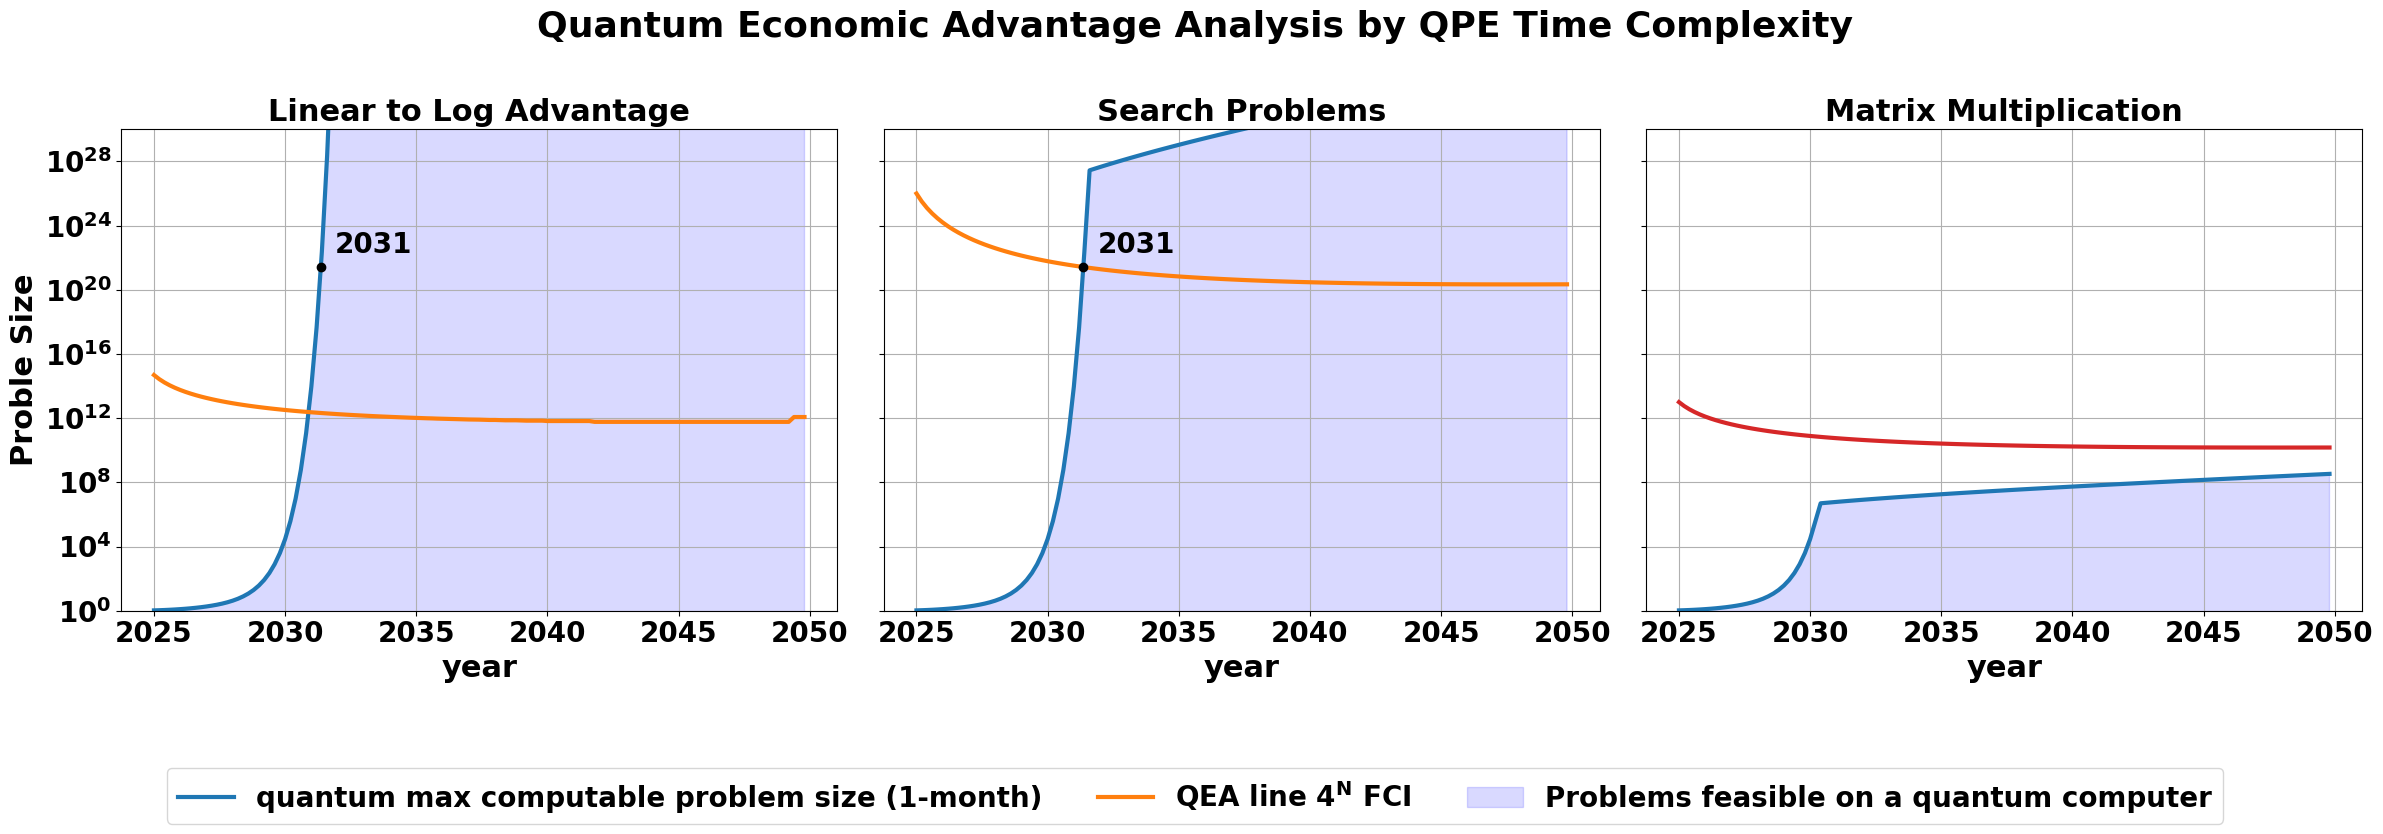

In [16]:
# Create a figure with three subplots side by side
fig, axes = plt.subplots(1, 3, figsize=(24, 8), sharey=True)
#(24,7)
plt.ylim(top=1e30)

#constant adjustment 
alg_overhead_qspeed = 1e0
alg_overhead_qubit = 1e0
classical_alg_overhead = 1e0

# Second subplot - n^2 QPE
classical_runtime_linear = "n"
quantum_runtime_log = "log(n,2)"



annotation_size = 20

quantum_problem_sizes_n2 = [
    find_largest_problem_size(quantum_runtime_log, year, quantum=True) for year in years
]
quantum_economic_advantages_fci_n2 = [
    quantum_advantage_size_by_year(year, classical_runtime_string=classical_runtime_linear, quantum_runtime_string=quantum_runtime_log) for year in years
]
def find_largest_problem_size_func_n2(year):
    return find_largest_problem_size(quantum_runtime_log, year, quantum=True)




axes[0].plot(years, quantum_problem_sizes_n2, label="quantum max computable problem size (1-month)", linewidth=3)
axes[0].plot(years, quantum_economic_advantages_fci_n2, label=r"QEA line $\mathbf{4^N}$ FCI", linewidth=3)
axes[0].set_xlabel("year", fontsize=22, fontweight='bold')
axes[0].tick_params(axis='both', which='major', labelsize=20)  # Removed invalid labelweight parameter
for label in axes[0].get_xticklabels() + axes[0].get_yticklabels():
    label.set_fontweight('bold')
axes[0].set_yscale("log")
axes[0].set_title(r"Linear to Log Advantage", fontsize=22, fontweight='bold')
axes[0].grid()
axes[0].set_ylim(1e0)
axes[0].fill_between(years, 0, quantum_problem_sizes_n2,
                   color='blue', alpha=0.15, label='Problems feasible on a quantum computer')
# Plot intersection points for n^2 QPE
intersection_year_fci_n2 = binary_search_intersection(
    find_largest_problem_size_func_n2,
    lambda year: quantum_advantage_size_by_year(year, classical_runtime_string=classical_runtime_search, quantum_runtime_string=quantum_runtime),
    2025, 2050
)
intersection_value_fci_n2 = find_largest_problem_size(quantum_runtime, intersection_year_fci_n2, quantum=True)
axes[0].plot(intersection_year_fci_n2, intersection_value_fci_n2, 'ro', color="black")
axes[0].annotate(f'{int(round(intersection_year_fci_n2))}',
               xy=(intersection_year_fci_n2, intersection_value_fci_n2),
               xytext=(10, 10), textcoords='offset points', fontsize=annotation_size, fontweight='bold')

axes[0].set_ylabel("Proble Size", fontsize=22, fontweight='bold')


#Quadratic Search Optimizations 
# First subplot: n^3 QPE
# ... existing code ...
years = np.arange(2025, 2050, .2)

# First subplot - n^3 QPE
quantum_runtime_search = "n**0.5"
classical_runtime_search = "n"

quantum_problem_sizes_n3 = [
    find_largest_problem_size(quantum_runtime_search, year, quantum=True) for year in years
]

quantum_economic_advantages_fci_n3 = [
    quantum_advantage_size_by_year(year, classical_runtime_string=classical_runtime_search, quantum_runtime_string=quantum_runtime_search) for year in years
]

def find_largest_problem_size_func_n3(year):
    return find_largest_problem_size(quantum_runtime_search, year, quantum=True)

axes[1].plot(years, quantum_problem_sizes_n3, label="quantum max computable problem size (1-month)", linewidth=3)
axes[1].plot(years, quantum_economic_advantages_fci_n3, label=r"QEA line $4^N$ FCI", linewidth=3)


axes[1].set_xlabel("year", fontsize=22, fontweight='bold')
axes[1].tick_params(axis='both', which='major', labelsize=20)  # Removed invalid labelweight parameter
for label in axes[1].get_xticklabels() + axes[1].get_yticklabels():
    label.set_fontweight('bold')
axes[1].set_yscale("log")
axes[1].set_title(r"Search Problems", fontsize=22, fontweight='bold')
axes[1].grid()
# axes[1].set_ylim(1e0) #why this here

axes[1].fill_between(years, 0, quantum_problem_sizes_n3,
                   color='blue', alpha=0.15, label='problems feasible on a quantum computer')

# Plot intersection points for n^3 QPE
intersection_year_fci_n3 = binary_search_intersection(
    find_largest_problem_size_func_n3,
    lambda year: quantum_advantage_size_by_year(year, classical_runtime_string=classical_runtime_search, quantum_runtime_string=quantum_runtime_search),
    2025, 2050
)
intersection_value_fci_n3 = find_largest_problem_size(quantum_runtime_search, intersection_year_fci_n3, quantum=True)
axes[1].plot(intersection_year_fci_n3, intersection_value_fci_n3, 'ro', color="black")
axes[1].annotate(f'{int(round(intersection_year_fci_n3))}',
               xy=(intersection_year_fci_n3, intersection_value_fci_n3),
               xytext=(10, 10), textcoords='offset points', fontsize=annotation_size, fontweight='bold')



# ===============================================
#lets start here with matrix multiplication 
classical_runtime_matrix = "n**3"
quantum_runtime_matrix = "n**2"

quantum_problem_sizes_n5 = [
    find_largest_problem_size(quantum_runtime_matrix, year, quantum=True) for year in years
]

quantum_economic_advantages_fci_n5 = [
    quantum_advantage_size_by_year(year, classical_runtime_string=classical_runtime_matrix, quantum_runtime_string=quantum_runtime_matrix) for year in years
]

def find_largest_problem_size_func_n5(year):
    return find_largest_problem_size(quantum_runtime_matrix, year, quantum=True)

axes[2].plot(years, quantum_problem_sizes_n5, label="quantum max computable problem size (1-week)", linewidth=3)
axes[2].plot(years, quantum_economic_advantages_fci_n5, label=r"QEA line $4^N$ FCI", linewidth=3, color="tab:red")

axes[2].set_xlabel("year", fontsize=22, fontweight='bold')
axes[2].tick_params(axis='both', which='major', labelsize=20)  # Removed invalid labelweight parameter
for label in axes[2].get_xticklabels() + axes[2].get_yticklabels():
    label.set_fontweight('bold')
axes[2].set_yscale("log")
axes[2].set_title(r"Matrix Multiplication", fontsize=22, fontweight='bold')
axes[2].grid()
axes[2].set_ylim(1e0)

axes[2].fill_between(years, 0, quantum_problem_sizes_n5,
                   color='blue', alpha=0.15, label='problems feasible on a quantum computer')

# Common legend for all subplots
handles, labels = axes[0].get_legend_handles_labels()

prop = {'size': 20, 'weight': 'bold'}
fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, 0.05), ncol=3, prop=prop)

# Add an overall title
fig.suptitle("Quantum Economic Advantage Analysis by QPE Time Complexity", fontsize=26, fontweight='bold', y=0.98)

# Adjust layout
plt.tight_layout(rect=[0, 0.12, 1, 0.95])  # Make room for the common legend at bottom
plt.savefig("Figures/qea_deeep_learning_comparison.png", bbox_inches='tight', dpi=300)

# Robustness to Change in Qubit Growth Rate

In [ ]:
# make 10 different roadmaps with different growth rates


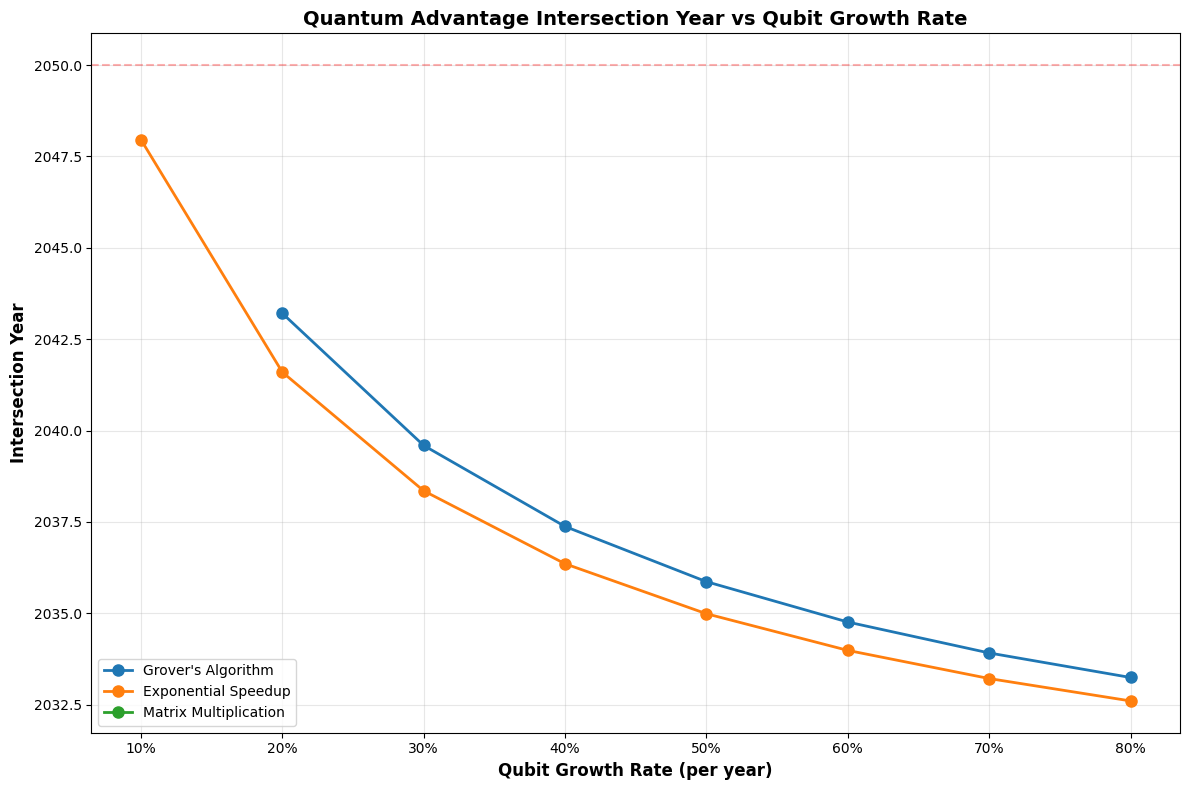


Numerical Results:
--------------------------------------------------------------------------------
Growth Rate Grover's Algorithm    Exponential Speedup   Matrix Multiplication 
--------------------------------------------------------------------------------
 10%        N/A                   2048.0                N/A                   
 20%        2043.2                2041.6                N/A                   
 30%        2039.6                2038.4                N/A                   
 40%        2037.4                2036.4                N/A                   
 50%        2035.9                2035.0                N/A                   
 60%        2034.8                2034.0                N/A                   
 70%        2033.9                2033.2                N/A                   
 80%        2033.2                2032.6                N/A                   


In [13]:
import numpy as np
import matplotlib.pyplot as plt

runtime_pairs = [
    ("n", "n**.5", "Grover's Algorithm"),
    ("n", "log(n,2)", "Exponential Speedup"),
    ("n**3", "n**2", "Matrix Multiplication")
]

# Modified get_intersection_year to accept roadmap parameter
def get_intersection_year(quantum_runtime, classical_runtime, roadmap=default_roadmap, start_year=2024, end_year=2050):
    """Find intersection year for given runtime pair and roadmap"""
    def find_largest_size(year):
        return find_largest_problem_size(quantum_runtime, year, quantum=True, roadmap=roadmap)
    def quantum_advantage_size(year):
        return quantum_advantage_size_by_year(year, classical_runtime, quantum_runtime)
    
    return binary_search_intersection(find_largest_size, quantum_advantage_size, start_year, end_year)


def create_roadmap(growth_rate, init_qubits=100, start_year=2024, num_years=10):
    return {start_year + i: int(init_qubits * (growth_rate)**i) for i in range(num_years)}


# Create a range of growth rates from 1.1 to 1.8
growth_rates = np.arange(1.1, 1.9, 0.1)

# Dictionary to store results for each algorithm
intersection_results = {name: [] for _, _, name in runtime_pairs}

# Calculate intersection years for each growth rate
for growth_rate in growth_rates:
    roadmap = create_roadmap(growth_rate)
    
    for classical_rt, quantum_rt, name in runtime_pairs:
        year = get_intersection_year(quantum_rt, classical_rt, roadmap)
        intersection_results[name].append(year)

# Create the plot
plt.figure(figsize=(12, 8))

# Plot lines for each algorithm
for name in intersection_results.keys():
    plt.plot(growth_rates, intersection_results[name], 'o-', label=name, linewidth=2, markersize=8)

plt.xlabel('Qubit Growth Rate (per year)', fontsize=12, fontweight='bold')
plt.ylabel('Intersection Year', fontsize=12, fontweight='bold')
plt.title('Quantum Advantage Intersection Year vs Qubit Growth Rate', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.legend(fontsize=10)

# Format x-axis to show percentages
plt.xticks(growth_rates, [f'{(rate-1)*100:.0f}%' for rate in growth_rates])

# Add horizontal line at 2050 to show upper limit
plt.axhline(y=2050, color='r', linestyle='--', alpha=0.3, label='Year 2050')

# Adjust layout to prevent label cutoff
plt.tight_layout()

# Save the figure
plt.savefig("Figures/intersection_year_vs_growth_rate.png", dpi=300, bbox_inches='tight')
plt.show()

# Print numerical results
print("\nNumerical Results:")
print("-" * 80)
print(f"{'Growth Rate':<12}", end="")
for name in intersection_results.keys():
    print(f"{name:<22}", end="")
print("\n" + "-" * 80)

for i, rate in enumerate(growth_rates):
    print(f"{(rate-1)*100:>3.0f}%{'':8}", end="")
    for name in intersection_results.keys():
        year = intersection_results[name][i]
        year_str = f"{year:.1f}" if year is not None else "N/A"
        print(f"{year_str:<22}", end="")
    print()

# Robustness to Quantum Constants

In [65]:
# Analyze intersection years for different classical improvement rates and algorithm types

error_reduction_rate = .2
gate_speed_improvement_rate = .15
classical_speed_init = 1/(5*1e9) # seconds
superconducting_gate_speed_init = (1/(5*1e9))*(10**3.78) # seconds
initial_error = 10**(-2.5)
classical_speed_improvement_rate = .3
number_of_processors = 1e5
constant_variations = [10**i for i in range(-3, 5, 1)]


# First runtime pair: n vs n^0.5
# Define runtime pairs
runtime_pairs = [
    ("n", "n**.5", "Grover's Algorithm"),
    ("n", "log(n,2)", "Exponential Speedup"),
    ("n**3", "n**2", "Matrix Multiplication")
]
# Get initial intersection years
initial_years = []
for classical_rt, quantum_rt, name in runtime_pairs:
    year = get_intersection_year(quantum_rt, classical_rt)
    initial_years.append(year)
    print(f"Initial intersection year for {name}: {year}")

# Analyze sensitivity to error reduction rate
classical_improvement_rates = np.arange(0.1, 0.9, 0.1)
intersection_results_quantum_constants = {name: [] for _, _, name in runtime_pairs}

for constant_variation in constant_variations:
    superconductor_gate_speed_init = superconductor_gate_speed_init*constant_variation
    for classical_rt, quantum_rt, name in runtime_pairs:
        year = get_intersection_year(quantum_rt, classical_rt, start_year=2024, end_year=2051)
        intersection_results_quantum_constants[name].append(year)


/Users/hansgundlach/Documents/AllOtherResearch/NeelMaterial/othello/lib/python3.9/site-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


Initial intersection year for Grover's Algorithm: 2048.6776577267447
Initial intersection year for Exponential Speedup: 2046.0574658570695
Initial intersection year for Matrix Multiplication: 2045.0088709927513


Text(0.5, 1.0, 'Intersection Year vs Quantum Constants for Different Runtime Complexities')

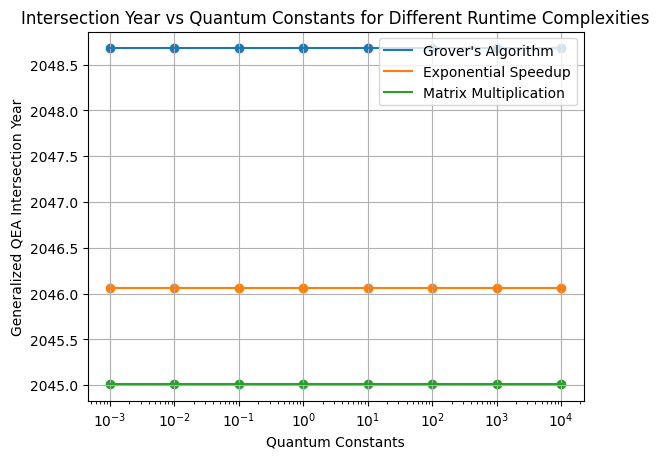

In [66]:
plt.plot(constant_variations, intersection_results_quantum_constants["Grover's Algorithm"], label="Grover's Algorithm")
plt.scatter(constant_variations, intersection_results_quantum_constants["Grover's Algorithm"])
plt.plot(constant_variations, intersection_results_quantum_constants["Exponential Speedup"], label="Exponential Speedup")
plt.scatter(constant_variations, intersection_results_quantum_constants["Exponential Speedup"])
plt.plot(constant_variations, intersection_results_quantum_constants["Matrix Multiplication"], label="Matrix Multiplication")
plt.scatter(constant_variations, intersection_results_quantum_constants["Matrix Multiplication"])
plt.ylabel("Generalized QEA Intersection Year")
plt.xlabel("Quantum Constants")
plt.xscale("log")
plt.grid(True)
plt.legend(loc="upper right")
plt.savefig("Figures/intersection_year_vs_classical_improvement_rate.png")
plt.title("Intersection Year vs Quantum Constants for Different Runtime Complexities")

# Robustness to Classical Constants

In [17]:
# C

Initial intersection year for Grover's Algorithm: None
Initial intersection year for Exponential Speedup: None
Initial intersection year for Matrix Multiplication: None


Text(0.5, 1.0, 'Intersection Year vs Quantum Constants for Different Runtime Complexities')

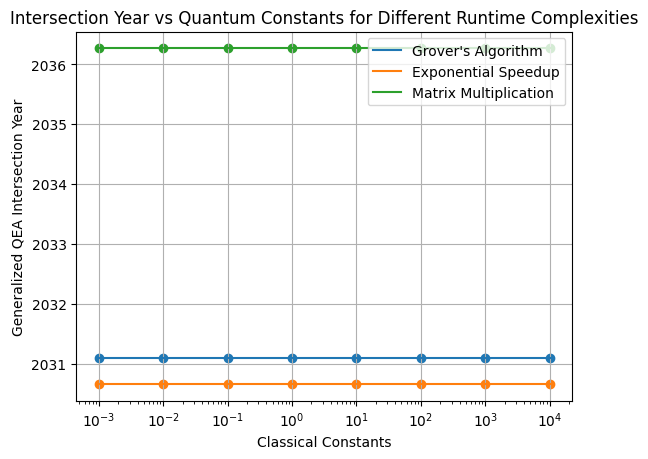

In [18]:
plt.plot(constant_variations, intersection_results_classical_constants["Grover's Algorithm"], label="Grover's Algorithm")
plt.scatter(constant_variations, intersection_results_classical_constants["Grover's Algorithm"])
plt.plot(constant_variations, intersection_results_classical_constants["Exponential Speedup"], label="Exponential Speedup")
plt.scatter(constant_variations, intersection_results_classical_constants["Exponential Speedup"])
plt.plot(constant_variations, intersection_results_classical_constants["Matrix Multiplication"], label="Matrix Multiplication")
plt.scatter(constant_variations, intersection_results_classical_constants["Matrix Multiplication"])
plt.ylabel("Generalized QEA Intersection Year")
plt.xlabel("Classical Constants")
plt.xscale("log")
plt.grid(True)
plt.legend(loc="upper right")
plt.savefig("Figures/intersection_year_vs_classical_improvement_rate.png")
plt.title("Intersection Year vs Quantum Constants for Different Runtime Complexities")

In [21]:
# find the intersection of quantum max computable problem size and quantum economic advantage use binary search intersection 
error_reduction_rate = .2
gate_speed_improvement_rate = .15
classical_speed_init = 1/(5*1e9) # seconds
superconducting_gate_speed_init = (1/(5*1e9))*(10**3.78) # seconds
initial_error = 10**(-2.5)
classical_speed_improvement_rate = .3
number_of_processors = 1e5


# First runtime pair: n vs n^0.5
# Define runtime pairs
runtime_pairs = [
    ("n", "n**.5", "Grover's Algorithm"),
    ("n", "log(n,2)", "Exponential Speedup"),
    ("n**3", "n**2", "Matrix Multiplication")
]

def get_intersection_year(quantum_runtime, classical_runtime, start_year=2024, end_year=2060):
    """Find intersection year for given runtime pair"""
    def find_largest_size(year):
        return find_largest_problem_size(quantum_runtime, year, quantum=True)
        
    def quantum_advantage_size(year):
        return quantum_advantage_size_by_year(year, classical_runtime, quantum_runtime)
        
    return binary_search_intersection(find_largest_size, quantum_advantage_size, start_year, end_year)

# Get initial intersection years
initial_years = []
for classical_rt, quantum_rt, name in runtime_pairs:
    year = get_intersection_year(quantum_rt, classical_rt)
    initial_years.append(year)
    print(f"Initial intersection year for {name}: {year}")

# Analyze sensitivity to error reduction rate
error_reduction_ranges = np.arange(0.1, 0.9, 0.1)
intersection_results_error_reduction = {name: [] for _, _, name in runtime_pairs}

for error_rate in error_reduction_ranges:
    error_reduction_rate = error_rate
    
    for classical_rt, quantum_rt, name in runtime_pairs:
        year = get_intersection_year(quantum_rt, classical_rt, start_year=2024, end_year=2051)
        intersection_results_error_reduction[name].append(year)

Initial intersection year for Grover's Algorithm: 2031.093479410105
Initial intersection year for Exponential Speedup: 2030.6535715322825
Initial intersection year for Matrix Multiplication: 2036.2674266195972


# Graph For Poster

# Sensitivity Analysis 

Things that could be varied: 
- with or without connectivity penalty 
-time limit for computational chemistry experiments 
-variation of algorithmic constants
- variation of roadmap and roadmap growth rate
- variation of other growth parameters like those in error and such 




In [104]:
# #bolder version for poster 
# classical_runtime = "1e-3*n**6"
# quantum_runtime = "1e3*n**3"
# classical_runtime_ccsdpt = "n**8"
# classical_runtime_fci = "2**n"
# # graph largeset problem size vs year for grovers algorithms
# years = np.arange(2025, 2050, .2)
# quantum_problem_sizes = [
#     find_largest_problem_size(quantum_runtime, year, quantum=True) for year in years
# ]
# print(classical_problem_sizes_ccsdpt)

# quantum_economic_advantages_ccsd = [
#     quantum_advantage_size_by_year(year, classical_runtime_string=classical_runtime, quantum_runtime_string=quantum_runtime) for year in years
# ]
# quantum_economic_advantages_ccsdpt = [
#     quantum_advantage_size_by_year(year, classical_runtime_string=classical_runtime_ccsdpt, quantum_runtime_string=quantum_runtime) for year in years
# ]
# quantum_economic_advantages_fci = [
#     quantum_advantage_size_by_year(year, classical_runtime_string=classical_runtime_fci, quantum_runtime_string=quantum_runtime) for year in years
# ]
# quantum_advantage_size_by_year_list= [
# quantum_advantage_size_by_year(year, classical_runtime_string=classical_runtime, quantum_runtime_string=quantum_runtime) for year in years
# ]

# def find_largest_problem_size_func(year):
#     return find_largest_problem_size(quantum_runtime, year, quantum=True)

# def quantum_advantage_size_by_year_func(year):
#     return quantum_advantage_size_by_year(year, classical_runtime_string=classical_runtime, quantum_runtime_string=quantum_runtime)
# # Find the intersection year using binary search
# intersection_year = binary_search_intersection(find_largest_problem_size_func, quantum_advantage_size_by_year_func, 2025, 2050)

# # Find the intersection value
# intersection_value = find_largest_problem_size(quantum_runtime, intersection_year, quantum=True)
# #====================================================================================================

# #plotting code 
# plt.figure(figsize=(10, 6))
# #plotting code 
# plt.plot(years, quantum_problem_sizes, label="quantum max computable problem size (1-week)", linewidth=3)
# plt.plot(years, quantum_economic_advantages_ccsd, label="quantum economic advantage ccsd", linewidth=3)
# plt.plot(years, quantum_economic_advantages_ccsdpt, label="quantum economic advantage ccsdpt", linewidth=3)
# plt.plot(years, quantum_economic_advantages_fci, label="quantum economic advantage fci", linewidth=3)
# # plt.plot(years, classical_problem_sizes_ccsd, label="ccsd max computable problem size (1-week)", linewidth=3)
# # plt.plot(years, classical_problem_sizes_stagnation, label="classical stagnation")
# # plt.plot(years, quantum_advantage_size_by_year_list, label="quantum economic advantage", linewidth=3)

# # plt.plot(years, classical_problem_sizes_ccsdpt, label="ccsdpt max computable problem size (1-week)", linewidth=3)
# plt.ylabel("problem size", fontsize=22, fontweight='bold')
# plt.xlabel("year", fontsize=22, fontweight='bold')
# tick_positions = np.logspace(0, 50, num=10, base=10)
# plt.xticks(fontsize=20, fontweight='bold')
# plt.yticks(fontsize=20, fontweight='bold')
# plt.yscale("log")
# plt.title("Quantum vs Classical Chemistry Methods (n^3 QPE)", fontsize=22, fontweight='bold')
# plt.grid() 
# #move the legend to the upper right
# plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.25), ncol=2, fontsize=15)

# plt.ylim(1e0)

# plt.fill_between(years, 0, quantum_problem_sizes,
#                     color='blue', alpha=0.15, label='Problems with Quantum Economic Advantage')
# # Adjust layout to prevent text cutoff

# #====================================================================
# # Find intersection between quantum max computable problem size and quantum economic advantage fci
# intersection_year_fci = binary_search_intersection(
#     find_largest_problem_size_func,
#     lambda year: quantum_advantage_size_by_year(year, classical_runtime_string=classical_runtime_fci, quantum_runtime_string=quantum_runtime),
#     2025, 2050
# )
# intersection_value_fci = find_largest_problem_size(quantum_runtime, intersection_year_fci, quantum=True)

# # Plot the intersection point
# plt.plot(intersection_year_fci, intersection_value_fci, 'ro', color="black")
# plt.annotate(f'{int(round(intersection_year_fci))}',
#             xy=(intersection_year_fci, intersection_value_fci),
#             xytext=(10, 10), textcoords='offset points', fontsize=15, fontweight='bold')

# #same as above but for ccsdpt

# intersection_year_ccsdpt = binary_search_intersection(
#     find_largest_problem_size_func,
#     lambda year: quantum_advantage_size_by_year(year, classical_runtime_string=classical_runtime_ccsdpt, quantum_runtime_string=quantum_runtime),
#     2025, 2050
# )
# intersection_value_ccsdpt = find_largest_problem_size(quantum_runtime, intersection_year_ccsdpt, quantum=True)
# plt.plot(intersection_year_ccsdpt, intersection_value_ccsdpt, 'ro', color="black")
# plt.annotate(f'{int(round(intersection_year_ccsdpt))}',
#             xy=(intersection_year_ccsdpt, intersection_value_ccsdpt),
#             xytext=(10, 10), textcoords='offset points', fontsize=15, fontweight='bold')



# plt.tight_layout(rect=[0, 0, 1, 0.95], pad=1.5)  # Add padding and adjust height
# plt.savefig("Figures/qea_chemistry_graph.png", bbox_inches='tight', dpi=300)  # Use bbox_inches to


# Intersection Table

In [ ]:
# # make table of generalized qea for n^3 quantum algorithm vs a variety of clasical algorithms with times n^5, n^6, and n^4

# # Create a table of generalized QEA for n^3 quantum algorithm vs classical algorithms of n^5, n^6, and n^8

# alg_overhead_qubit = 1e0
# # Define the algorithm complexities
# quantum_runtime = "1e3*n**3"
# classical_runtimes = {
#     "MP2 n^5": "n**5",
#     "CCSD n^6": "n**6", 
#     "CCSDPT n^7": "n**7",
#     "FCI 4**n": "4**n"
# }


# # Set a range of years to evaluate
# start_year = 2025
# end_year = 2050

# # Create a results dictionary to store our findings
# results = {
#     "Classical Complexity": [],
#     "QEA Year": [],
#     "Problem Size at QEA": [],
#     "Qubits Required": []
# }

# # Function to get number of qubits required for a problem size
# def qubits_required(problem_size):
#     # For chemistry problems, typically need O(n) qubits
#     # This is a simplified model - adjust based on your specific algorithm
#     return int(problem_size)  # Example: 2n qubits needed

# # Calculate QEA for each classical algorithm
# for name, classical_runtime_str in classical_runtimes.items():
#     try:
#         # Find the year when QEA is reached
#         qea_year = generalized_qea(
#             classical_runtime_string=classical_runtime_str,
#             quantum_runtime_string=quantum_runtime
#         )
        
#         if qea_year is not None:
#             # Find the problem size at QEA
#             problem_size = quantum_advantage_size_by_year(
#                 qea_year, 
#                 classical_runtime_str, 
#                 quantum_runtime
#             )
            
#             # Calculate qubits required
#             qubits = qubits_required(problem_size)
            
#             # Store results
#             results["Classical Complexity"].append(name)
#             results["QEA Year"].append(round(qea_year))
#             results["Problem Size at QEA"].append(round(problem_size))
#             results["Qubits Required"].append(qubits)
#         else:
#             # No QEA found in the specified range
#             results["Classical Complexity"].append(name)
#             results["QEA Year"].append("Beyond 2050")
#             results["Problem Size at QEA"].append("N/A")
#             results["Qubits Required"].append("N/A")
            
#     except Exception as e:
#         print(f"Error calculating QEA for {name}: {e}")
#         results["Classical Complexity"].append(name)
#         results["QEA Year"].append("Error")
#         results["Problem Size at QEA"].append("Error")
#         results["Qubits Required"].append("Error")

# # Create a pandas DataFrame from the results
# print("n^3 QPE analysis")
# results_df = pd.DataFrame(results)
# print(results_df)


# # make table of generalized qea for n^3 quantum algorithm vs a variety of clasical algorithms with times n^5, n^6, and n^4

# # Define the algorithm complexities
# quantum_runtime = "1e3*n**2"
# classical_runtimes = {
#     "DFT n^3": "n**3",
#     "HF n^4": "n**4",
#     "MP2 n^5": "n**5",
#     "CCSD n^6": "n**6", 
#     "CCSDPT n^7": "n**7",
#     "FCI 4**n": "4**n"
# }

# # Set a range of years to evaluate
# start_year = 2025
# end_year = 2050

# # Create a results dictionary to store our findings
# results = {
#     "Classical Complexity": [],
#     "QEA Year": [],
#     "Problem Size at QEA": [],
#     "Qubits Required": []
# }

# # Function to get number of qubits required for a problem size
# def qubits_required(problem_size):
#     # For chemistry problems, typically need O(n) qubits
#     # This is a simplified model - adjust based on your specific algorithm
#     return int(problem_size)  # Example: 2n qubits needed

# # Calculate QEA for each classical algorithm
# for name, classical_runtime_str in classical_runtimes.items():
#     try:
#         # Find the year when QEA is reached
#         qea_year = generalized_qea(
#             classical_runtime_string=classical_runtime_str,
#             quantum_runtime_string=quantum_runtime
#         )
        
#         if qea_year is not None:
#             # Find the problem size at QEA
#             problem_size = quantum_advantage_size_by_year(
#                 qea_year, 
#                 classical_runtime_str, 
#                 quantum_runtime
#             )
            
#             # Calculate qubits required
#             qubits = qubits_required(problem_size)
            
#             # Store results
#             results["Classical Complexity"].append(name)
#             results["QEA Year"].append(round(qea_year))
#             # print("the qea year of ", name, "is ", qea_year)
#             results["Problem Size at QEA"].append(round(problem_size))
#             results["Qubits Required"].append(qubits)
#         else:
#             # No QEA found in the specified range
#             results["Classical Complexity"].append(name)
#             results["QEA Year"].append("Beyond 2050")
#             results["Problem Size at QEA"].append("N/A")
#             results["Qubits Required"].append("N/A")
            
#     except Exception as e:
#         print(f"Error calculating QEA for {name}: {e}")
#         results["Classical Complexity"].append(name)
#         results["QEA Year"].append("Error")
#         results["Problem Size at QEA"].append("Error")
#         results["Qubits Required"].append("Error")

# # Create a pandas DataFrame from the results
# results_df = pd.DataFrame(results)
# print("n^2 QPE analysis")
# print(results_df)






# Experiments with constants and logical qubit requirements

# Original For Comparison

In [56]:
# make table of generalized qea for n^3 quantum algorithm vs a variety of clasical algorithms with times n^5, n^6, and n^4
print("examing robustness with orginal parameters")
# Create a table of generalized QEA for n^3 quantum algorithm vs classical algorithms of n^5, n^6, and n^8
# algorithm overhead in logical qubits 
alg_overhead_qspeed = 1e0
alg_overhead_qubit = 1e1
classical_alg_overhead = 1e0
# Define the algorithm complexities
quantum_runtime = "1e3*n**3"
classical_runtimes = {
    "HF n^4": "n**4",
    "MP2 n^5": "n**5",
    "CCSD n^6": "n**6", 
    "CCSDPT n^7": "n**7",
    "FCI 4**n": "4**n"
}


# Set a range of years to evaluate
start_year = 2025
end_year = 2050

# Create a results dictionary to store our findings
results = {
    "Classical Complexity": [],
    "QEA Year": [],
    "Problem Size at QEA": [],
    "Qubits Required": []
}

# Function to get number of qubits required for a problem size
def qubits_required(problem_size):
    # For chemistry problems, typically need O(n) qubits
    # This is a simplified model - adjust based on your specific algorithm
    return int(problem_size)  # Example: 2n qubits needed

# Calculate QEA for each classical algorithm
for name, classical_runtime_str in classical_runtimes.items():
    try:
        # Find the year when QEA is reached
        qea_year = generalized_qea(
            classical_runtime_string=classical_runtime_str,
            quantum_runtime_string=quantum_runtime
        )
        
        if qea_year is not None:
            # Find the problem size at QEA
            problem_size = quantum_advantage_size_by_year(
                qea_year, 
                classical_runtime_str, 
                quantum_runtime
            )
            
            # Calculate qubits required
            qubits = qubits_required(problem_size)
            
            # Store results
            results["Classical Complexity"].append(name)
            results["QEA Year"].append(round(qea_year))
            results["Problem Size at QEA"].append(round(problem_size))
            results["Qubits Required"].append(qubits)
        else:
            # No QEA found in the specified range
            results["Classical Complexity"].append(name)
            results["QEA Year"].append("Beyond 2050")
            results["Problem Size at QEA"].append("N/A")
            results["Qubits Required"].append("N/A")
            
    except Exception as e:
        print(f"Error calculating QEA for {name}: {e}")
        results["Classical Complexity"].append(name)
        results["QEA Year"].append("Error")
        results["Problem Size at QEA"].append("Error")
        results["Qubits Required"].append("Error")

# Create a pandas DataFrame from the results
print("n^3 QPE analysis")
results_df = pd.DataFrame(results)
print(results_df)


# make table of generalized qea for n^3 quantum algorithm vs a variety of clasical algorithms with times n^5, n^6, and n^4

# Define the algorithm complexities
quantum_runtime = "1e3*n**2"
classical_runtimes = {
    "HF n^4": "n**4",
    "MP2 n^5": "n**5",
    "CCSD n^6": "n**6", 
    "CCSDPT n^7": "n**7",
    "FCI 4**n": "4**n"
}

# Set a range of years to evaluate
start_year = 2025
end_year = 2050

# Create a results dictionary to store our findings
results = {
    "Classical Complexity": [],
    "QEA Year": [],
    "Problem Size at QEA": [],
    "Qubits Required": []
}

# Function to get number of qubits required for a problem size
def qubits_required(problem_size):
    # For chemistry problems, typically need O(n) qubits
    # This is a simplified model - adjust based on your specific algorithm
    return int(problem_size)  # Example: 2n qubits needed

# Calculate QEA for each classical algorithm
for name, classical_runtime_str in classical_runtimes.items():
    try:
        # Find the year when QEA is reached
        qea_year = generalized_qea(
            classical_runtime_string=classical_runtime_str,
            quantum_runtime_string=quantum_runtime
        )
        
        if qea_year is not None:
            # Find the problem size at QEA
            problem_size = quantum_advantage_size_by_year(
                qea_year, 
                classical_runtime_str, 
                quantum_runtime
            )
            
            # Calculate qubits required
            qubits = qubits_required(problem_size)
            
            # Store results
            results["Classical Complexity"].append(name)
            results["QEA Year"].append(round(qea_year))
            # print("the qea year of ", name, "is ", qea_year)
            results["Problem Size at QEA"].append(round(problem_size))
            results["Qubits Required"].append(qubits)
        else:
            # No QEA found in the specified range
            results["Classical Complexity"].append(name)
            results["QEA Year"].append("Beyond 2050")
            results["Problem Size at QEA"].append("N/A")
            results["Qubits Required"].append("N/A")
            
    except Exception as e:
        print(f"Error calculating QEA for {name}: {e}")
        results["Classical Complexity"].append(name)
        results["QEA Year"].append("Error")
        results["Problem Size at QEA"].append("Error")
        results["Qubits Required"].append("Error")

# Create a pandas DataFrame from the results
results_df = pd.DataFrame(results)
print("n^2 QPE analysis")
print(results_df)






examing robustness with orginal parameters
No sign change in f(x) over the interval; intersection not guaranteed.
No sign change in f(x) over the interval; intersection not guaranteed.
n^3 QPE analysis
  Classical Complexity     QEA Year Problem Size at QEA Qubits Required
0               HF n^4  Beyond 2050                 N/A             N/A
1              MP2 n^5  Beyond 2050                 N/A             N/A
2             CCSD n^6         2044               24721           24721
3           CCSDPT n^7         2036                2208            2207
4             FCI 4**n         2032                  30              30
n^2 QPE analysis
  Classical Complexity  QEA Year  Problem Size at QEA  Qubits Required
0               HF n^4      2044              3886894          3886894
1              MP2 n^5      2038                26647            26646
2             CCSD n^6      2036                 2208             2207
3           CCSDPT n^7      2034                  492            

# Experiment 1 changed qubit requirements 

In [ ]:
# make table of generalized qea for n^3 quantum algorithm vs a variety of clasical algorithms with times n^5, n^6, and n^4

print("examing robustness with changed qubit requirements")

# Create a table of generalized QEA for n^3 quantum algorithm vs classical algorithms of n^5, n^6, and n^ # algorithm overhead in logical qubits 
alg_overhead_qspeed = 1e0
alg_overhead_qubit = 1e-1
classical_alg_overhead_speed = 1e0
# Define the algorithm complexities
quantum_runtime = "1e3*n**3"
classical_runtimes = {
    "MP2 n^5": "n**5",
    "CCSD n^6": "n**6", 
    "CCSDPT n^7": "n**7",
    "FCI 4**n": "4**n"
}


# Set a range of years to evaluate
start_year = 2025
end_year = 2050

# Create a results dictionary to store our findings
results = {
    "Classical Complexity": [],
    "QEA Year": [],
    "Problem Size at QEA": [],
    "Qubits Required": []
}

# Function to get number of qubits required for a problem size
def qubits_required(problem_size):
    # For chemistry problems, typically need O(n) qubits
    # This is a simplified model - adjust based on your specific algorithm
    return int(problem_size)  # Example: 2n qubits needed

# Calculate QEA for each classical algorithm
for name, classical_runtime_str in classical_runtimes.items():
    try:
        # Find the year when QEA is reached
        qea_year = generalized_qea(
            classical_runtime_string=classical_runtime_str,
            quantum_runtime_string=quantum_runtime
        )
        
        if qea_year is not None:
            # Find the problem size at QEA
            problem_size = quantum_advantage_size_by_year(
                qea_year, 
                classical_runtime_str, 
                quantum_runtime
            )
            
            # Calculate qubits required
            qubits = qubits_required(problem_size)
            
            # Store results
            results["Classical Complexity"].append(name)
            results["QEA Year"].append(round(qea_year))
            results["Problem Size at QEA"].append(round(problem_size))
            results["Qubits Required"].append(qubits)
        else:
            # No QEA found in the specified range
            results["Classical Complexity"].append(name)
            results["QEA Year"].append("Beyond 2050")
            results["Problem Size at QEA"].append("N/A")
            results["Qubits Required"].append("N/A")
            
    except Exception as e:
        print(f"Error calculating QEA for {name}: {e}")
        results["Classical Complexity"].append(name)
        results["QEA Year"].append("Error")
        results["Problem Size at QEA"].append("Error")
        results["Qubits Required"].append("Error")

# Create a pandas DataFrame from the results
print("n^3 QPE analysis")
results_df = pd.DataFrame(results)
print(results_df)


# make table of generalized qea for n^3 quantum algorithm vs a variety of clasical algorithms with times n^5, n^6, and n^4

# Define the algorithm complexities
quantum_runtime = "1e3*n**2"
classical_runtimes = {
    "DFT n^3": "n**3",
    "HF n^4": "n**4",
    "MP2 n^5": "n**5",
    "CCSD n^6": "n**6", 
    "CCSDPT n^7": "n**7",
    "FCI 4**n": "4**n"
}

# Set a range of years to evaluate
start_year = 2025
end_year = 2050

# Create a results dictionary to store our findings
results = {
    "Classical Complexity": [],
    "QEA Year": [],
    "Problem Size at QEA": [],
    "Qubits Required": []
}

# Function to get number of qubits required for a problem size
def qubits_required(problem_size):
    # For chemistry problems, typically need O(n) qubits
    # This is a simplified model - adjust based on your specific algorithm
    return int(problem_size)  # Example: 2n qubits needed

# Calculate QEA for each classical algorithm
for name, classical_runtime_str in classical_runtimes.items():
    try:
        # Find the year when QEA is reached
        qea_year = generalized_qea(
            classical_runtime_string=classical_runtime_str,
            quantum_runtime_string=quantum_runtime
        )
        
        if qea_year is not None:
            # Find the problem size at QEA
            problem_size = quantum_advantage_size_by_year(
                qea_year, 
                classical_runtime_str, 
                quantum_runtime
            )
            
            # Calculate qubits required
            qubits = qubits_required(problem_size)
            
            # Store results
            results["Classical Complexity"].append(name)
            results["QEA Year"].append(round(qea_year))
            # print("the qea year of ", name, "is ", qea_year)
            results["Problem Size at QEA"].append(round(problem_size))
            results["Qubits Required"].append(qubits)
        else:
            # No QEA found in the specified range
            results["Classical Complexity"].append(name)
            results["QEA Year"].append("Beyond 2050")
            results["Problem Size at QEA"].append("N/A")
            results["Qubits Required"].append("N/A")
            
    except Exception as e:
        print(f"Error calculating QEA for {name}: {e}")
        results["Classical Complexity"].append(name)
        results["QEA Year"].append("Error")
        results["Problem Size at QEA"].append("Error")
        results["Qubits Required"].append("Error")

# Create a pandas DataFrame from the results
results_df = pd.DataFrame(results)
print("n^2 QPE analysis")
print(results_df)






# Examine Robustness To Constants

In [61]:
# make table of generalized qea for n^3 quantum algorithm vs a variety of clasical algorithms with times n^5, n^6, and n^4
print("examing robustness with slower quantum algorithms")
# Create a table of generalized QEA for n^3 quantum algorithm vs classical algorithms of n^5, n^6, and n^8
# algorithm overhead in logical qubits 
alg_overhead_qspeed = 1e1
alg_overhead_qubit = 1e1
classical_alg_overhead = 1e0
# Define the algorithm complexities
quantum_runtime = "1e3*n**3"
classical_runtimes = {
    "MP2 n^5": "n**5",
    "CCSD n^6": "n**6", 
    "CCSDPT n^7": "n**7",
    "FCI 4**n": "4**n"
}


# Set a range of years to evaluate
start_year = 2025
end_year = 2050

# Create a results dictionary to store our findings
results = {
    "Classical Complexity": [],
    "QEA Year": [],
    "Problem Size at QEA": [],
    "Qubits Required": []
}

# Function to get number of qubits required for a problem size
def qubits_required(problem_size):
    # For chemistry problems, typically need O(n) qubits
    # This is a simplified model - adjust based on your specific algorithm
    return int(problem_size)  # Example: 2n qubits needed

# Calculate QEA for each classical algorithm
for name, classical_runtime_str in classical_runtimes.items():
    try:
        # Find the year when QEA is reached
        qea_year = generalized_qea(
            classical_runtime_string=classical_runtime_str,
            quantum_runtime_string=quantum_runtime
        )
        
        if qea_year is not None:
            # Find the problem size at QEA
            problem_size = quantum_advantage_size_by_year(
                qea_year, 
                classical_runtime_str, 
                quantum_runtime
            )
            
            # Calculate qubits required
            qubits = qubits_required(problem_size)
            
            # Store results
            results["Classical Complexity"].append(name)
            results["QEA Year"].append(round(qea_year))
            results["Problem Size at QEA"].append(round(problem_size))
            results["Qubits Required"].append(qubits)
        else:
            # No QEA found in the specified range
            results["Classical Complexity"].append(name)
            results["QEA Year"].append("Beyond 2050")
            results["Problem Size at QEA"].append("N/A")
            results["Qubits Required"].append("N/A")
            
    except Exception as e:
        print(f"Error calculating QEA for {name}: {e}")
        results["Classical Complexity"].append(name)
        results["QEA Year"].append("Error")
        results["Problem Size at QEA"].append("Error")
        results["Qubits Required"].append("Error")

# Create a pandas DataFrame from the results
print("n^3 QPE analysis")
results_df = pd.DataFrame(results)
print(results_df)


# make table of generalized qea for n^3 quantum algorithm vs a variety of clasical algorithms with times n^5, n^6, and n^4

# Define the algorithm complexities
quantum_runtime = "1e3*n**2"
classical_runtimes = {
    "DFT n^3": "n**3",
    "HF n^4": "n**4",
    "MP2 n^5": "n**5",
    "CCSD n^6": "n**6", 
    "CCSDPT n^7": "n**7",
    "FCI 4**n": "4**n"
}

# Set a range of years to evaluate
start_year = 2025
end_year = 2050

# Create a results dictionary to store our findings
results = {
    "Classical Complexity": [],
    "QEA Year": [],
    "Problem Size at QEA": [],
    "Qubits Required": []
}

# Function to get number of qubits required for a problem size
def qubits_required(problem_size):
    # For chemistry problems, typically need O(n) qubits
    # This is a simplified model - adjust based on your specific algorithm
    return int(problem_size)  # Example: 2n qubits needed

# Calculate QEA for each classical algorithm
for name, classical_runtime_str in classical_runtimes.items():
    try:
        # Find the year when QEA is reached
        qea_year = generalized_qea(
            classical_runtime_string=classical_runtime_str,
            quantum_runtime_string=quantum_runtime
        )
        
        if qea_year is not None:
            # Find the problem size at QEA
            problem_size = quantum_advantage_size_by_year(
                qea_year, 
                classical_runtime_str, 
                quantum_runtime
            )
            
            # Calculate qubits required
            qubits = qubits_required(problem_size)
            
            # Store results
            results["Classical Complexity"].append(name)
            results["QEA Year"].append(round(qea_year))
            # print("the qea year of ", name, "is ", qea_year)
            results["Problem Size at QEA"].append(round(problem_size))
            results["Qubits Required"].append(qubits)
        else:
            # No QEA found in the specified range
            results["Classical Complexity"].append(name)
            results["QEA Year"].append("Beyond 2050")
            results["Problem Size at QEA"].append("N/A")
            results["Qubits Required"].append("N/A")
            
    except Exception as e:
        print(f"Error calculating QEA for {name}: {e}")
        results["Classical Complexity"].append(name)
        results["QEA Year"].append("Error")
        results["Problem Size at QEA"].append("Error")
        results["Qubits Required"].append("Error")

# Create a pandas DataFrame from the results
results_df = pd.DataFrame(results)
print("n^2 QPE analysis")
print(results_df)






examing robustness with slower quantum algorithms
No sign change in f(x) over the interval; intersection not guaranteed.
No sign change in f(x) over the interval; intersection not guaranteed.
n^3 QPE analysis
  Classical Complexity     QEA Year Problem Size at QEA Qubits Required
0              MP2 n^5  Beyond 2050                 N/A             N/A
1             CCSD n^6  Beyond 2050                 N/A             N/A
2           CCSDPT n^7         2036                3867            3866
3             FCI 4**n         2032                  32              31
No sign change in f(x) over the interval; intersection not guaranteed.
No sign change in f(x) over the interval; intersection not guaranteed.
n^2 QPE analysis
  Classical Complexity     QEA Year Problem Size at QEA Qubits Required
0              DFT n^3  Beyond 2050                 N/A             N/A
1               HF n^4  Beyond 2050                 N/A             N/A
2              MP2 n^5         2039               56460 

In [52]:
#examing robustness to increased classical algorithm speed
print("examing robustness to increased classical algorithm speed")

alg_overhead_qspeed = 1e0
alg_overhead_qubit = 1e0
classical_alg_overhead = 1e0
# Define the algorithm complexities
quantum_runtime = "1e3*n**3"
classical_runtimes = {
    "HF n^4": "n**4",
    "MP2 n^5": "n**5",
    "CCSD n^6": "n**6", 
    "CCSDPT n^7": "n**7",
    "FCI 4**n": "4**n"
}


# Set a range of years to evaluate
start_year = 2025
end_year = 2050

# Create a results dictionary to store our findings
results = {
    "Classical Complexity": [],
    "QEA Year": [],
    "Problem Size at QEA": [],
    "Qubits Required": []
}

# Function to get number of qubits required for a problem size
def qubits_required(problem_size):
    # For chemistry problems, typically need O(n) qubits
    # This is a simplified model - adjust based on your specific algorithm
    return int(problem_size)  # Example: 2n qubits needed

# Calculate QEA for each classical algorithm
for name, classical_runtime_str in classical_runtimes.items():
    try:
        # Find the year when QEA is reached
        qea_year = generalized_qea(
            classical_runtime_string=classical_runtime_str,
            quantum_runtime_string=quantum_runtime
        )
        
        if qea_year is not None:
            # Find the problem size at QEA
            problem_size = quantum_advantage_size_by_year(
                qea_year, 
                classical_runtime_str, 
                quantum_runtime
            )
            
            # Calculate qubits required
            qubits = qubits_required(problem_size)
            
            # Store results
            results["Classical Complexity"].append(name)
            results["QEA Year"].append(round(qea_year))
            results["Problem Size at QEA"].append(round(problem_size))
            results["Qubits Required"].append(qubits)
        else:
            # No QEA found in the specified range
            results["Classical Complexity"].append(name)
            results["QEA Year"].append("Beyond 2050")
            results["Problem Size at QEA"].append("N/A")
            results["Qubits Required"].append("N/A")
            
    except Exception as e:
        print(f"Error calculating QEA for {name}: {e}")
        results["Classical Complexity"].append(name)
        results["QEA Year"].append("Error")
        results["Problem Size at QEA"].append("Error")
        results["Qubits Required"].append("Error")

# Create a pandas DataFrame from the results
print("n^3 QPE analysis")
results_df = pd.DataFrame(results)
print(results_df)


# make table of generalized qea for n^3 quantum algorithm vs a variety of clasical algorithms with times n^5, n^6, and n^4

# Define the algorithm complexities
quantum_runtime = "1e3*n**2"
classical_runtimes = {
    "HF n^4": "n**4",
    "MP2 n^5": "n**5",
    "CCSD n^6": "n**6", 
    "CCSDPT n^7": "n**7",
    "FCI 4**n": "4**n"
}

# Set a range of years to evaluate
start_year = 2025
end_year = 2050

# Create a results dictionary to store our findings
results = {
    "Classical Complexity": [],
    "QEA Year": [],
    "Problem Size at QEA": [],
    "Qubits Required": []
}

# Function to get number of qubits required for a problem size
def qubits_required(problem_size):
    # For chemistry problems, typically need O(n) qubits
    # This is a simplified model - adjust based on your specific algorithm
    return int(problem_size)  # Example: 2n qubits needed

# Calculate QEA for each classical algorithm
for name, classical_runtime_str in classical_runtimes.items():
    try:
        # Find the year when QEA is reached
        qea_year = generalized_qea(
            classical_runtime_string=classical_runtime_str,
            quantum_runtime_string=quantum_runtime
        )
        
        if qea_year is not None:
            # Find the problem size at QEA
            problem_size = quantum_advantage_size_by_year(
                qea_year, 
                classical_runtime_str, 
                quantum_runtime
            )
            
            # Calculate qubits required
            qubits = qubits_required(problem_size)
            
            # Store results
            results["Classical Complexity"].append(name)
            results["QEA Year"].append(round(qea_year))
            # print("the qea year of ", name, "is ", qea_year)
            results["Problem Size at QEA"].append(round(problem_size))
            results["Qubits Required"].append(qubits)
        else:
            # No QEA found in the specified range
            results["Classical Complexity"].append(name)
            results["QEA Year"].append("Beyond 2050")
            results["Problem Size at QEA"].append("N/A")
            results["Qubits Required"].append("N/A")
            
    except Exception as e:
        print(f"Error calculating QEA for {name}: {e}")
        results["Classical Complexity"].append(name)
        results["QEA Year"].append("Error")
        results["Problem Size at QEA"].append("Error")
        results["Qubits Required"].append("Error")

# Create a pandas DataFrame from the results
results_df = pd.DataFrame(results)
print("n^2 QPE analysis")
print(results_df)

examing robustness to increased classical algorithm speed
No sign change in f(x) over the interval; intersection not guaranteed.
No sign change in f(x) over the interval; intersection not guaranteed.
n^3 QPE analysis
  Classical Complexity     QEA Year Problem Size at QEA Qubits Required
0               HF n^4  Beyond 2050                 N/A             N/A
1              MP2 n^5  Beyond 2050                 N/A             N/A
2             CCSD n^6         2044               24721           24721
3           CCSDPT n^7         2034                2385            2384
4             FCI 4**n         2029                  31              30
n^2 QPE analysis
  Classical Complexity  QEA Year  Problem Size at QEA  Qubits Required
0               HF n^4      2044              3886894          3886894
1              MP2 n^5      2036                28478            28477
2             CCSD n^6      2034                 2385             2384
3           CCSDPT n^7      2032                  

# Doing Some Calculations

In [26]:
print(f"{(192**3)*(1e3):e}")
print(f"{(192**5)*(1e3):e}")
print(f"{(60000**3)*(1e3):e}")
print(f"alg constant {(960*9.8*1e13)/(966**6):e}")
print(f"alg constant {(8.4*1e12*61200)/(315**7):e}")



7.077888e+09
2.609193e+14
2.160000e+17
alg constant 1.157803e-01
alg constant 1.670540e+00
